In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import platform
import seaborn as sns
import matplotlib.pyplot as plt

## 導入數據集

In [2]:
theOS = list(platform.uname())[0]
if theOS == 'Windows':
    theOS = '\\'
    theEncode = 'utf-8-sig'
else:
    theOS = '/'
    theEncode = 'utf-8'

df = pd.read_csv('../data/ta_feng_all_months_merged.csv')
df

,TRANSACTION_DT,CUSTOMER_ID,AGE_GROUP,PIN_CODE,PRODUCT_SUBCLASS,PRODUCT_ID,AMOUNT,ASSET,SALES_PRICE
0,11/1/2000,1104905,45-49,115,110411,4710199010372,2,24,30
1,11/1/2000,418683,45-49,115,120107,4710857472535,1,48,46
2,11/1/2000,1057331,35-39,115,100407,4710043654103,2,142,166
3,11/1/2000,1849332,45-49,Others,120108,4710126092129,1,32,38
4,11/1/2000,1981995,50-54,115,100205,4710176021445,1,14,18
...,...,...,...,...,...,...,...,...,...
817736,2/28/2001,312790,35-39,114,530501,4713317035042,2,80,118
817737,2/28/2001,57486,40-44,115,530209,4710731060124,1,40,55
817738,2/28/2001,733526,>65,Unknown,510539,4716340052307,1,78,115
817739,2/28/2001,173704,45-49,115,520457,4714276145315,1,90,96


## 數據整理

In [3]:
## 時間格式轉換
df['Date'] = pd.to_datetime(df['TRANSACTION_DT'])
## 增加一筆用來計算頻率的欄位
df['count'] = 1
## 創建訂單ID
df['ORDER_ID'] = df.index

## 挑出商品購買頻率前五名的產品種類

In [4]:
product_five = df.groupby('PRODUCT_SUBCLASS')['count'].sum().sort_values(ascending = False)[:5]
product_five

PRODUCT_SUBCLASS
100205    20400
120103    15360
110401    13099
110411    12794
130206    12008
Name: count, dtype: int64

## 過濾數據集：進留下這五項明星商品種類

In [5]:
new_df = df[df['PRODUCT_SUBCLASS'].isin(product_five.index)]
new_df

,TRANSACTION_DT,CUSTOMER_ID,AGE_GROUP,PIN_CODE,PRODUCT_SUBCLASS,PRODUCT_ID,AMOUNT,ASSET,SALES_PRICE,Date,count,ORDER_ID
0,11/1/2000,1104905,45-49,115,110411,4710199010372,2,24,30,2000-11-01,1,0
4,11/1/2000,1981995,50-54,115,100205,4710176021445,1,14,18,2000-11-01,1,4
28,11/1/2000,768566,NaN,115,110401,4710088410443,1,40,55,2000-11-01,1,28
36,11/1/2000,1849332,45-49,Others,120103,4710011405133,1,23,28,2000-11-01,1,36
37,11/1/2000,1849332,45-49,Others,110411,4710085120628,2,40,37,2000-11-01,1,37
...,...,...,...,...,...,...,...,...,...,...,...,...
817683,2/28/2001,906456,25-29,115,100205,37000329206,1,38,45,2001-02-28,1,817683
817715,2/28/2001,1211115,35-39,110,100205,4710015202721,1,14,18,2001-02-28,1,817715
817719,2/28/2001,87049,35-39,221,110411,4710249000834,1,29,37,2001-02-28,1,817719
817725,2/28/2001,300650,25-29,115,130206,20557003,1,99,99,2001-02-28,1,817725


## 購買頻率計算 Frequency

#### 生成每個商品在每個訂單的購買概況

In [6]:
purchase_list = new_df.pivot_table(index = ['CUSTOMER_ID', 'ORDER_ID', 'PIN_CODE', 'Date', 'AGE_GROUP'],
                                    columns='PRODUCT_SUBCLASS',
                                    aggfunc=sum,
                                    values='AMOUNT'
                                    ).fillna(0).reset_index()
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,ORDER_ID,PIN_CODE,Date,AGE_GROUP,100205,110401,110411,120103,130206
0,1250,623618,114,2001-02-10,35-39,1.0,0.0,0.0,0.0,0.0
1,1250,624360,114,2001-02-10,35-39,1.0,0.0,0.0,0.0,0.0
2,1250,625617,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0
3,1250,626748,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0
4,1250,628013,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
71323,2179544,813198,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,1.0
71324,2179605,802147,Others,2001-02-28,25-29,1.0,0.0,0.0,0.0,0.0
71325,2179605,803703,Others,2001-02-28,25-29,0.0,0.0,0.0,0.0,1.0
71326,2179605,805396,Others,2001-02-28,25-29,2.0,0.0,0.0,0.0,0.0


#### 計算每個消費者在一定期間內購買該商品的次數

In [7]:
purchase_list['frequency'] = 1

frequency = purchase_list.groupby("CUSTOMER_ID",
as_index= False)['frequency'].sum()

del purchase_list['frequency']
frequency

PRODUCT_SUBCLASS,CUSTOMER_ID,frequency
0,1250,6
1,5241,5
2,5517,5
3,6378,1
4,6668,6
...,...,...
17118,2179414,2
17119,2179469,1
17120,2179513,6
17121,2179544,3


## 最近一次消費計算 Recency

In [8]:
# 設定今天的日期為最近一位顧客購買的日期,從那天來看過往的銷售狀況
theToday = new_df['Date'].max()
# 找出每個顧客最近一次的購買日期
recent_recency = purchase_list.groupby("CUSTOMER_ID", as_index = False)['Date'].max()
# 計算消費者至今再次購買與上次購買產品的時間差
recent_recency['recency'] =( theToday - recent_recency['Date'] ).astype(str)
recent_recency

PRODUCT_SUBCLASS,CUSTOMER_ID,Date,recency
0,1250,2001-02-10,18 days
1,5241,2001-01-16,43 days
2,5517,2000-12-23,67 days
3,6378,2001-02-14,14 days
4,6668,2001-01-06,53 days
...,...,...,...
17118,2179414,2001-02-28,0 days
17119,2179469,2001-02-28,0 days
17120,2179513,2001-02-28,0 days
17121,2179544,2001-02-28,0 days


In [9]:
# 将'recency'欄位中的days去除
recent_recency['recency'] = recent_recency['recency'].str.replace('days.*',
                                                                  '',
                                                                  regex = True)
recent_recency

PRODUCT_SUBCLASS,CUSTOMER_ID,Date,recency
0,1250,2001-02-10,18
1,5241,2001-01-16,43
2,5517,2000-12-23,67
3,6378,2001-02-14,14
4,6668,2001-01-06,53
...,...,...,...
17118,2179414,2001-02-28,0
17119,2179469,2001-02-28,0
17120,2179513,2001-02-28,0
17121,2179544,2001-02-28,0


## 合併 Frequency 跟 Recency 

In [10]:
# 合併recency
recent_recency['recency'] = recent_recency['recency'].astype(int)
purchase_list = recent_recency.merge(purchase_list, on = ['CUSTOMER_ID', 'Date'] ,how='inner')

# 合併 frequency

purchase_list = purchase_list.merge(frequency,
                                    on = ['CUSTOMER_ID'], 
                                    how='inner')
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,Date,recency,ORDER_ID,PIN_CODE,AGE_GROUP,100205,110401,110411,120103,130206,frequency
0,1250,2001-02-10,18,623618,114,35-39,1.0,0.0,0.0,0.0,0.0,6
1,1250,2001-02-10,18,624360,114,35-39,1.0,0.0,0.0,0.0,0.0,6
2,1250,2001-02-10,18,625617,114,35-39,2.0,0.0,0.0,0.0,0.0,6
3,1250,2001-02-10,18,626748,114,35-39,0.0,0.0,1.0,0.0,0.0,6
4,1250,2001-02-10,18,628013,114,35-39,2.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
33256,2179544,2001-02-28,0,813198,Others,55-59,0.0,0.0,0.0,0.0,1.0,3
33257,2179605,2001-02-28,0,802147,Others,25-29,1.0,0.0,0.0,0.0,0.0,4
33258,2179605,2001-02-28,0,803703,Others,25-29,0.0,0.0,0.0,0.0,1.0,4
33259,2179605,2001-02-28,0,805396,Others,25-29,2.0,0.0,0.0,0.0,0.0,4


## 檢查 Frequency跟Recency獨有的數值，來決定區間

In [11]:
print(purchase_list['recency'].unique())
print(purchase_list['frequency'].unique())

[ 18  43  67  14  53  17  47  16  89  11  41 115   8  70  66  68 101  46
  22   4   3  32   7  12  91  24  87  37  81  33  36  25  83  39  71  95
 118 109   5  38  79   2 106  80  42   6  96  97  28   1  93  44  74  13
 107  94  45  75  20  76   0  72  40  92  73  88  19 111  21 102  86 108
  27  90  35 105  49 117  31   9  10  26  30  48 110  29 104  52 113  69
  57 112  15 116  64 100  54  65  55  84  34  61  51  77  59  82  58  23
 114  85  60 103  63  50  56  78  62  98  99 119]
[  6   5   1   4   2  14   7  19 107   8   3  23  10  17  20  25  16  12
  24   9  13  15  38  35  40  11  21  22  28  41  18  48  36  27  34  52
  30  29  26  37  43  39  31  68  57  32  33  46  42  55  50  45  53  99
  66  74  86  56  47  71  61  77]


## 定義Recency區間

這邊我將近期購買天數劃成六個區間: '0-14天', '16-31天', '32-46天', '47-51天', '52- 66天', '大於66天'

In [12]:
recency_label =  ['0-14 day', '16-31 day', '32-46 day', '47-51 day', '52- 66day', '>66 day']
recency_cut  = [-1, 14, 31, 46, 51, 66, purchase_list['recency'].max()]
purchase_list['recency_cate'] = pd.cut( 
        purchase_list['recency'],
        recency_cut,
        labels =recency_label)
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,Date,recency,ORDER_ID,PIN_CODE,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency_cate
0,1250,2001-02-10,18,623618,114,35-39,1.0,0.0,0.0,0.0,0.0,6,16-31 day
1,1250,2001-02-10,18,624360,114,35-39,1.0,0.0,0.0,0.0,0.0,6,16-31 day
2,1250,2001-02-10,18,625617,114,35-39,2.0,0.0,0.0,0.0,0.0,6,16-31 day
3,1250,2001-02-10,18,626748,114,35-39,0.0,0.0,1.0,0.0,0.0,6,16-31 day
4,1250,2001-02-10,18,628013,114,35-39,2.0,0.0,0.0,0.0,0.0,6,16-31 day
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33256,2179544,2001-02-28,0,813198,Others,55-59,0.0,0.0,0.0,0.0,1.0,3,0-14 day
33257,2179605,2001-02-28,0,802147,Others,25-29,1.0,0.0,0.0,0.0,0.0,4,0-14 day
33258,2179605,2001-02-28,0,803703,Others,25-29,0.0,0.0,0.0,0.0,1.0,4,0-14 day
33259,2179605,2001-02-28,0,805396,Others,25-29,2.0,0.0,0.0,0.0,0.0,4,0-14 day


## 定義Frequency區間

這邊我將每個顧客在四個月期間內購買該商品的數量劃分成六個區間:['0到10個', '11到20個', '21到30個', '31到40個', '41到50個', '大於50個']

In [13]:
frequency_label =  ['0~10 freq', '11~20 freq', '21~30 freq', '31~40 freq', '41~50 freq', '>50 freq']
frequency_cut  = [0, 10, 20, 30, 40, 50, purchase_list['frequency'].max()]
purchase_list['frequency_cate'] = pd.cut( 
        purchase_list['frequency'] , #目標欄位
        frequency_cut,  #切割條件
        labels =frequency_label) #切割後的分類內容
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,Date,recency,ORDER_ID,PIN_CODE,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency_cate,frequency_cate
0,1250,2001-02-10,18,623618,114,35-39,1.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq
1,1250,2001-02-10,18,624360,114,35-39,1.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq
2,1250,2001-02-10,18,625617,114,35-39,2.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq
3,1250,2001-02-10,18,626748,114,35-39,0.0,0.0,1.0,0.0,0.0,6,16-31 day,0~10 freq
4,1250,2001-02-10,18,628013,114,35-39,2.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33256,2179544,2001-02-28,0,813198,Others,55-59,0.0,0.0,0.0,0.0,1.0,3,0-14 day,0~10 freq
33257,2179605,2001-02-28,0,802147,Others,25-29,1.0,0.0,0.0,0.0,0.0,4,0-14 day,0~10 freq
33258,2179605,2001-02-28,0,803703,Others,25-29,0.0,0.0,0.0,0.0,1.0,4,0-14 day,0~10 freq
33259,2179605,2001-02-28,0,805396,Others,25-29,2.0,0.0,0.0,0.0,0.0,4,0-14 day,0~10 freq


## RFM 交叉分析

In [14]:
RF_table = pd.crosstab(purchase_list['frequency_cate'].astype(str),
                       purchase_list['recency_cate'].astype(str))
# 重新排序
RF_table['freq'] = RF_table.index
RF_table = RF_table.sort_values('freq',ascending = False)

collist = ['freq'] + recency_label
RF_table = RF_table[collist]

RF_table

recency_cate,freq,0-14 day,16-31 day,32-46 day,47-51 day,52- 66day,>66 day
frequency_cate,,,,,,,
>50 freq,>50 freq,55,11,0,0,0,0
41~50 freq,41~50 freq,46,0,0,0,0,0
31~40 freq,31~40 freq,106,50,0,0,0,0
21~30 freq,21~30 freq,354,160,80,4,9,8
11~20 freq,11~20 freq,1332,717,716,30,86,323
0~10 freq,0~10 freq,5507,5093,5645,709,2327,9893


## 定義客群

我將使用Frequency(購買數量)和Recency(近期購買天數)當條件來區分客群

1. Frequency(購買數量)大於40次且Recency(近期購買天數)小於46天的客群: 常貴客
2. Frequency(購買數量)大於40次且Recency(近期購買天數)大於46天的客群: 沉睡客
3. Frequency(購買數量)小於40次且Recency(近期購買天數)大於46天的客群: 流失客
4. 其他則為新顧客

In [15]:
purchase_list['customer'] = np.where( (purchase_list['frequency'] >=frequency_cut[4]) & (purchase_list['recency']<=recency_cut[3]), '常貴客',
   
                            np.where( (purchase_list['frequency'] >=frequency_cut[4]) & ( purchase_list['recency']>recency_cut[3]), '沉睡客',
                              
                            np.where( (purchase_list['frequency'] < frequency_cut[4]) & ( purchase_list['recency']>recency_cut[3]), '流失客',
                                       
                                       '新顧客'  )))
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,Date,recency,ORDER_ID,PIN_CODE,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency_cate,frequency_cate,customer
0,1250,2001-02-10,18,623618,114,35-39,1.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
1,1250,2001-02-10,18,624360,114,35-39,1.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
2,1250,2001-02-10,18,625617,114,35-39,2.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
3,1250,2001-02-10,18,626748,114,35-39,0.0,0.0,1.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
4,1250,2001-02-10,18,628013,114,35-39,2.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33256,2179544,2001-02-28,0,813198,Others,55-59,0.0,0.0,0.0,0.0,1.0,3,0-14 day,0~10 freq,新顧客
33257,2179605,2001-02-28,0,802147,Others,25-29,1.0,0.0,0.0,0.0,0.0,4,0-14 day,0~10 freq,新顧客
33258,2179605,2001-02-28,0,803703,Others,25-29,0.0,0.0,0.0,0.0,1.0,4,0-14 day,0~10 freq,新顧客
33259,2179605,2001-02-28,0,805396,Others,25-29,2.0,0.0,0.0,0.0,0.0,4,0-14 day,0~10 freq,新顧客


In [16]:
## 保存檔案
purchase_list.to_csv('purchase_list.csv', encoding=theEncode)

## 畫出RFM圖

In [17]:
theOS = list(platform.uname())[0]
if theOS == 'Windows':
    theOS = '\\'
    theEncode = 'utf-8-sig'
else:
    theOS = '/'
    theEncode = 'utf-8'

purchase_list = pd.read_csv('purchase_list.csv')
purchase_list = purchase_list.drop(columns=['Unnamed: 0'])
purchase_list

,CUSTOMER_ID,Date,recency,ORDER_ID,PIN_CODE,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency_cate,frequency_cate,customer
0,1250,2001-02-10,18,623618,114,35-39,1.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
1,1250,2001-02-10,18,624360,114,35-39,1.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
2,1250,2001-02-10,18,625617,114,35-39,2.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
3,1250,2001-02-10,18,626748,114,35-39,0.0,0.0,1.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
4,1250,2001-02-10,18,628013,114,35-39,2.0,0.0,0.0,0.0,0.0,6,16-31 day,0~10 freq,新顧客
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33256,2179544,2001-02-28,0,813198,Others,55-59,0.0,0.0,0.0,0.0,1.0,3,0-14 day,0~10 freq,新顧客
33257,2179605,2001-02-28,0,802147,Others,25-29,1.0,0.0,0.0,0.0,0.0,4,0-14 day,0~10 freq,新顧客
33258,2179605,2001-02-28,0,803703,Others,25-29,0.0,0.0,0.0,0.0,1.0,4,0-14 day,0~10 freq,新顧客
33259,2179605,2001-02-28,0,805396,Others,25-29,2.0,0.0,0.0,0.0,0.0,4,0-14 day,0~10 freq,新顧客


In [18]:
## 定義x, y軸標籤
recency_label = ['0-14 day', '16-31 day', '32-46 day', '47-51 day', '52- 66day', '>66 day']
frequency_label = ['0~10 freq', '11~20 freq', '21~30 freq', '31~40 freq', '41~50 freq', '>50 freq']

## 商品種類: 100205 來畫RFM

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/665969973.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


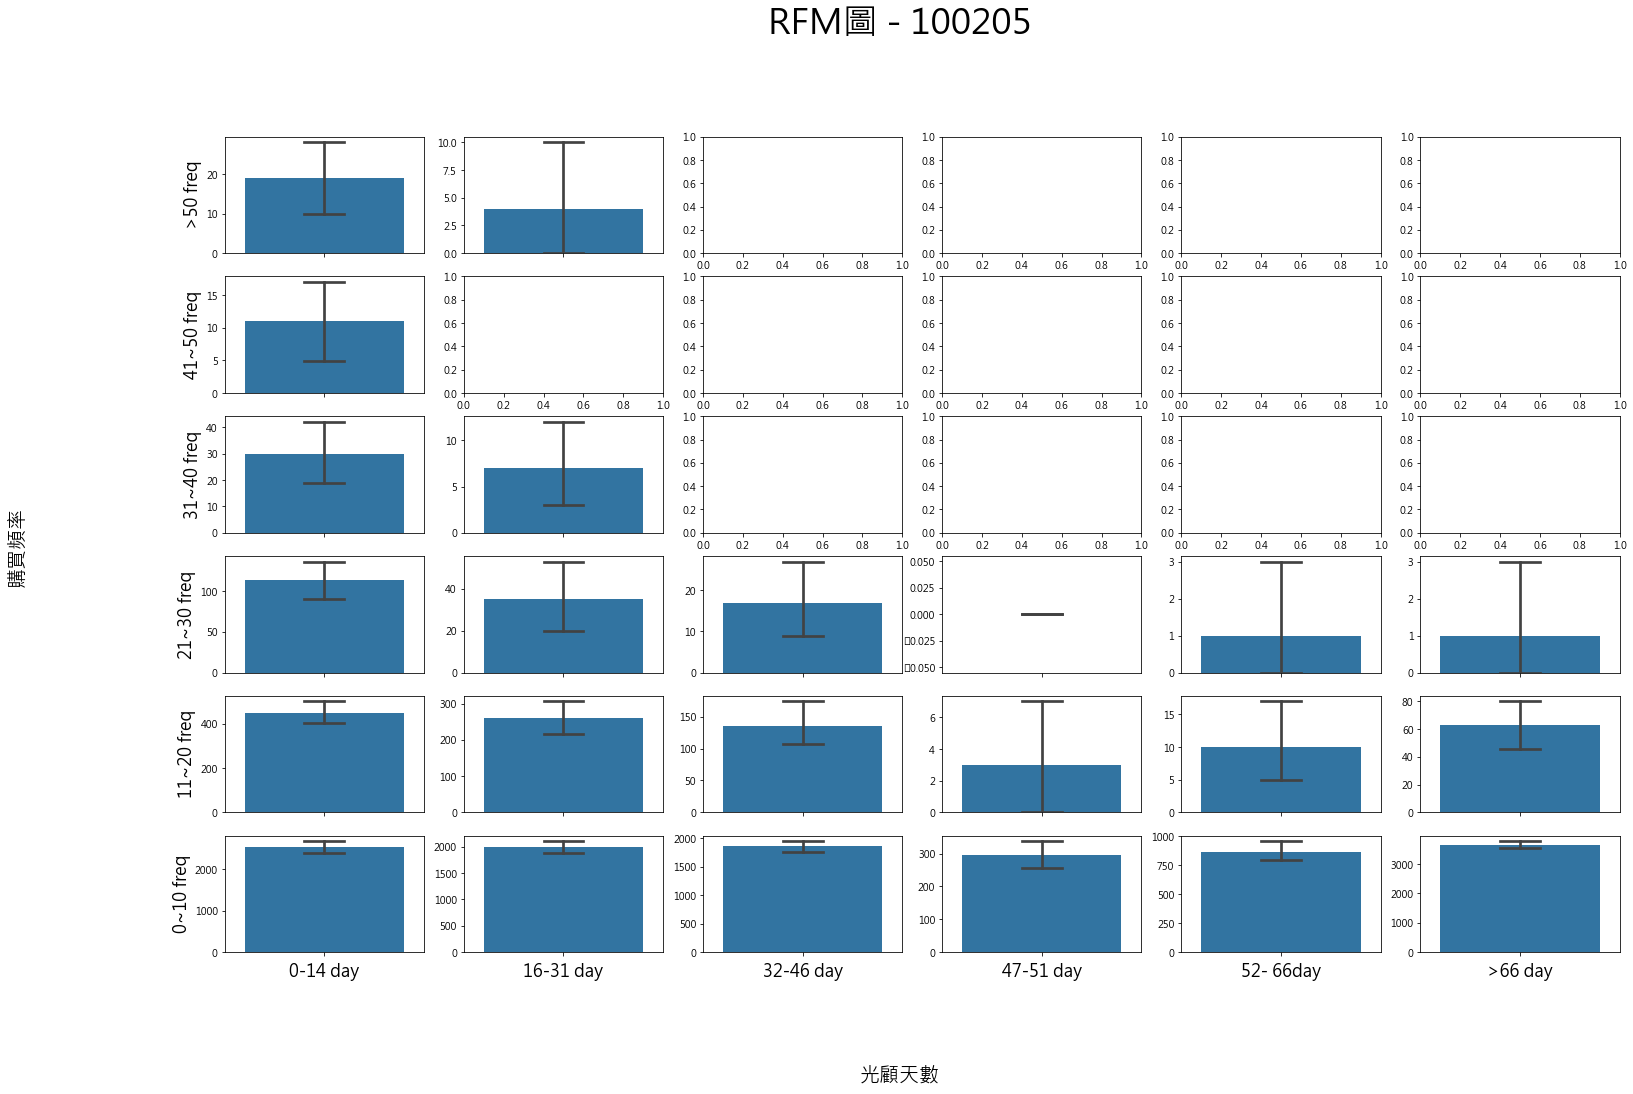

In [19]:
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標

for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y="100205", # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標
        ################ 畫X標籤 ################
        if i == '0~10 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)
            
        ############### 畫Y標籤 ################
        if j == '0-14 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - 100205', position=(.5,1), fontsize=35) # 設定標題
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20) # 設定X軸標題
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20) # 設定Y軸標題
fig.show()

## 進一步區分顧客群

1.綠色: 常貴客
2.藍色: 新顧客
3.黃色: 沉睡客
4.紅色: 流失客

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/632235135.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


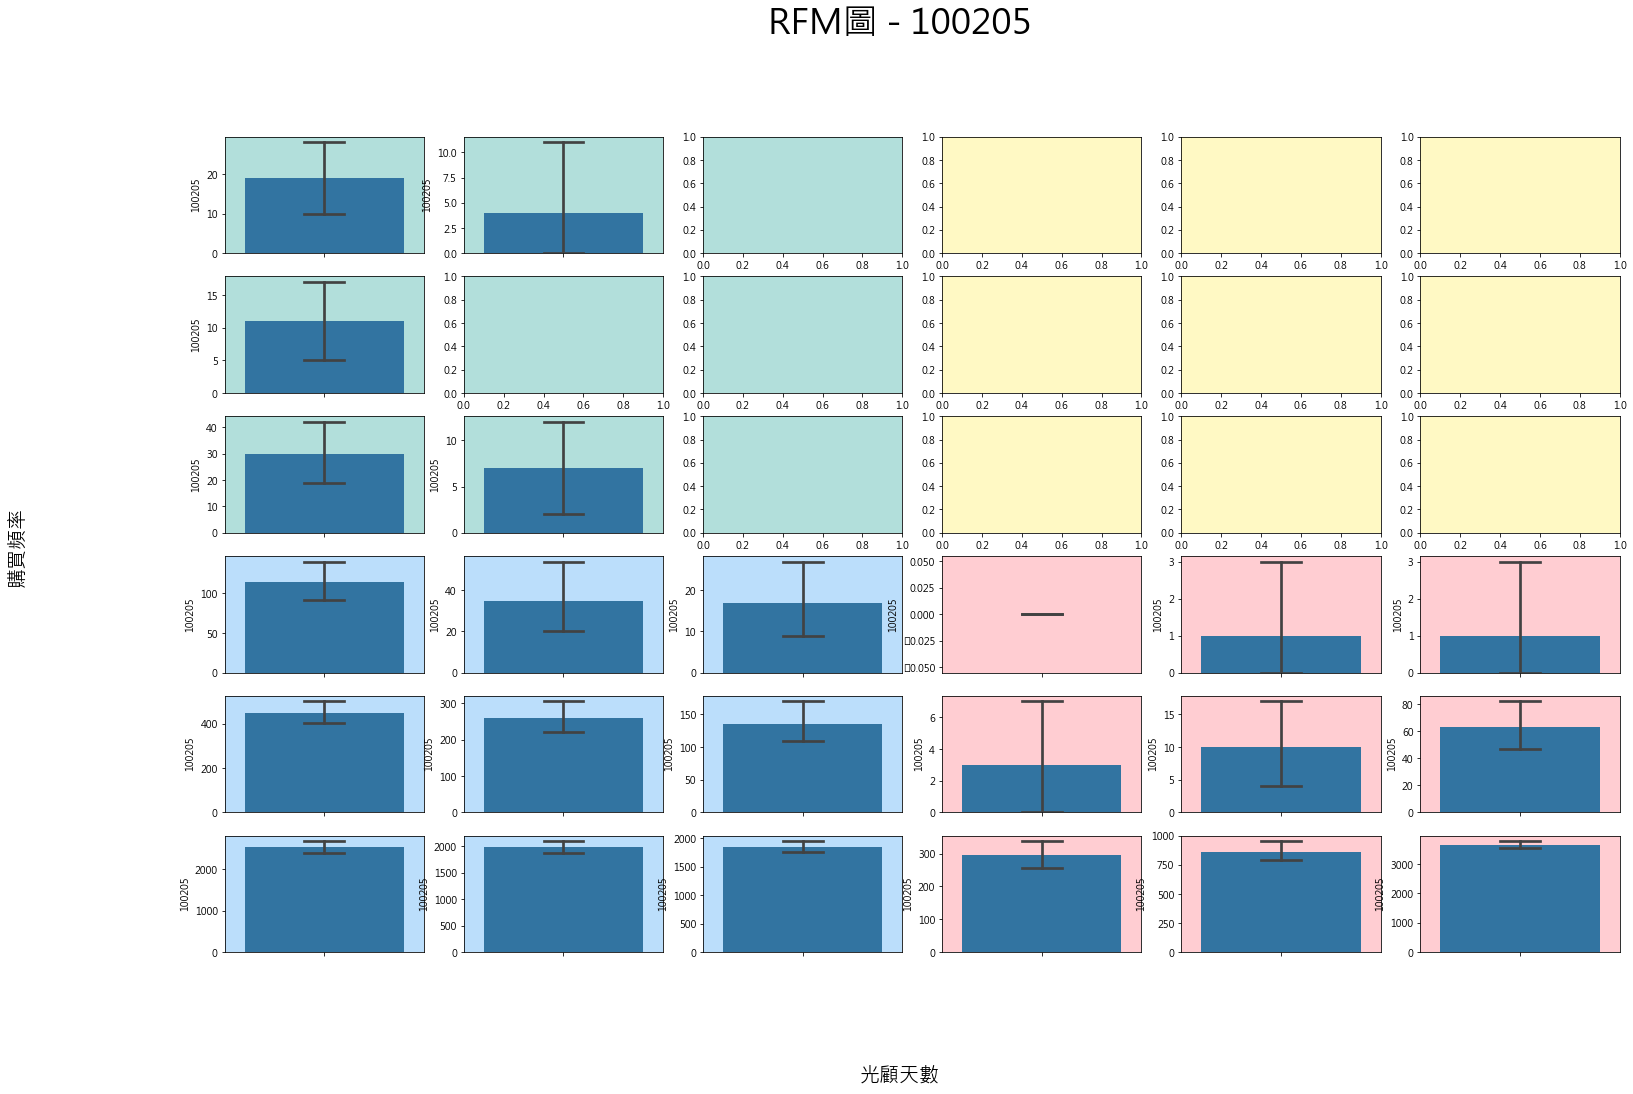

In [20]:
target_product = '100205'
# findbig=0
# for i in frequency_label:
#     for j in recency_label:
#         data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
#         if data[target_product].sum() > findbig:
#             findbig = data[target_product].sum()


#--- 繪圖
#先設定畫布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標
for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y=target_product, # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標

        ############### 四個區塊分顏色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #紅色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #藍色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #綠色
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - '+target_product, position=(.5,1), fontsize=35) # 設定標題
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20) # 設定X軸標題
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20) # 設定Y軸標題
fig.show()

## 商品種類: 110401 來畫RFM

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/3044900073.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


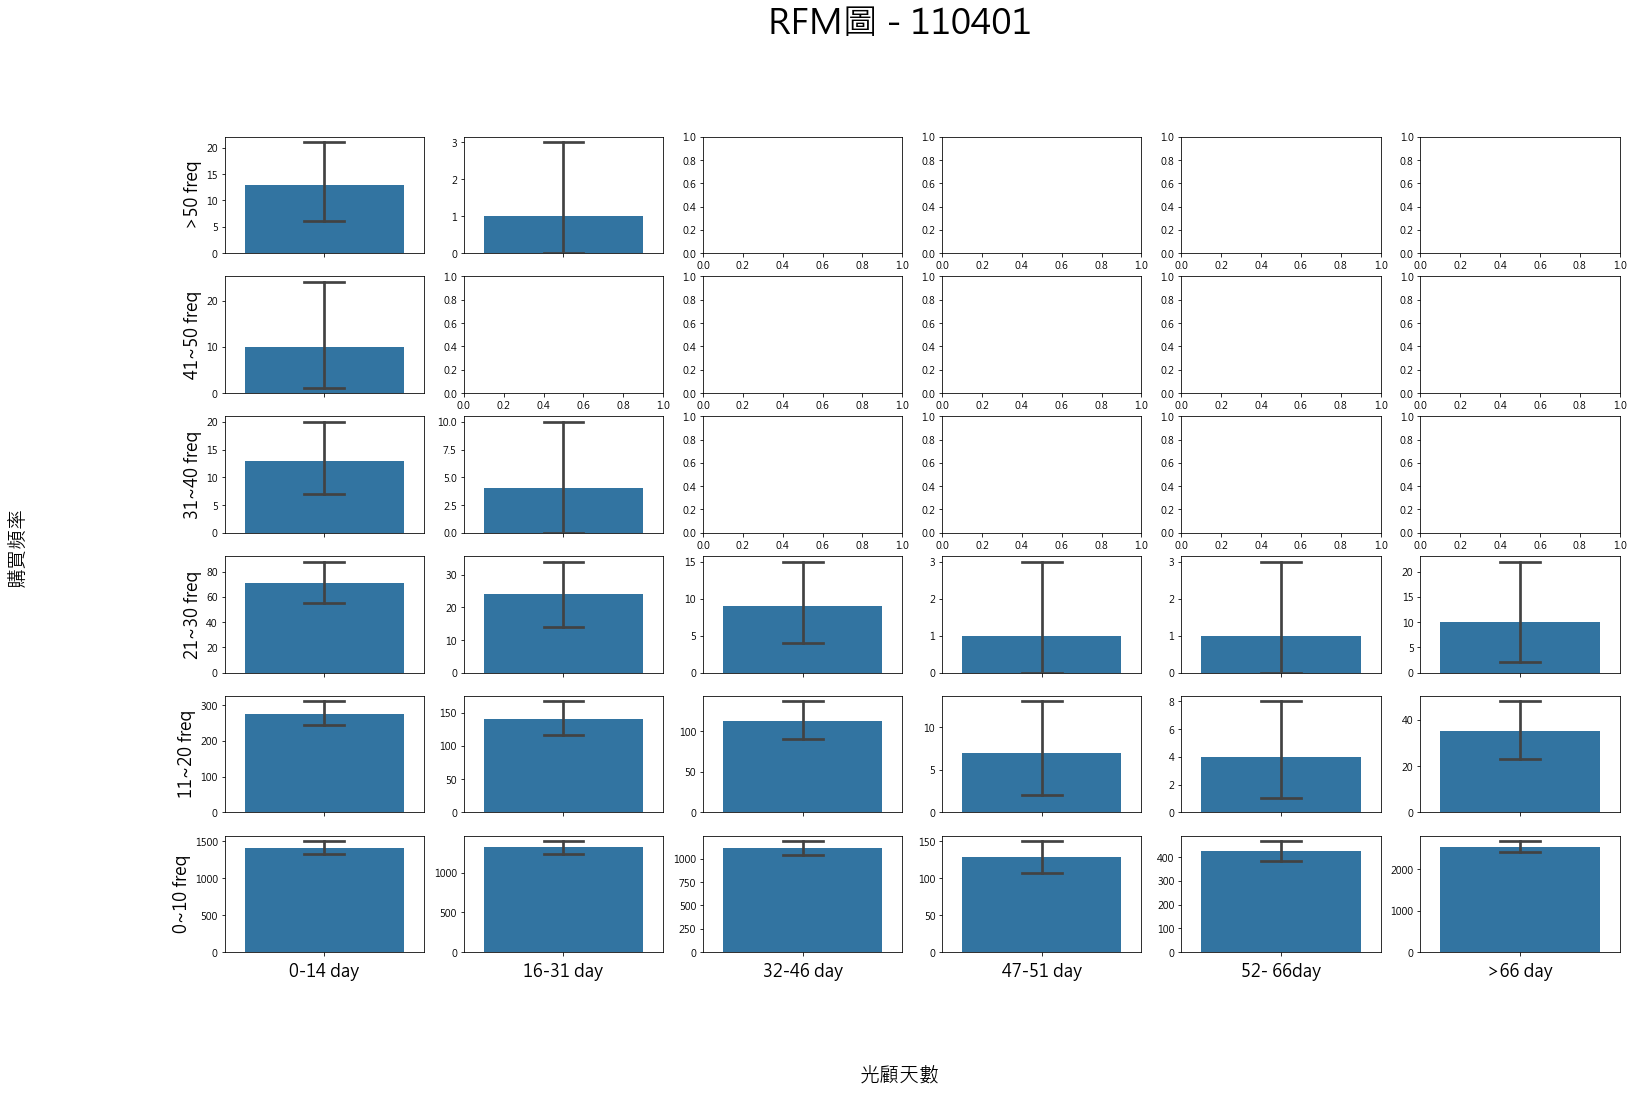

In [21]:
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標

for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y="110401", # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標
        ################ 畫X標籤 ################
        if i == '0~10 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)
            
        ############### 畫Y標籤 ################
        if j == '0-14 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - 110401', position=(.5,1), fontsize=35) # 設定標題
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20) # 設定X軸標題
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20) # 設定Y軸標題
fig.show()

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/2455124263.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


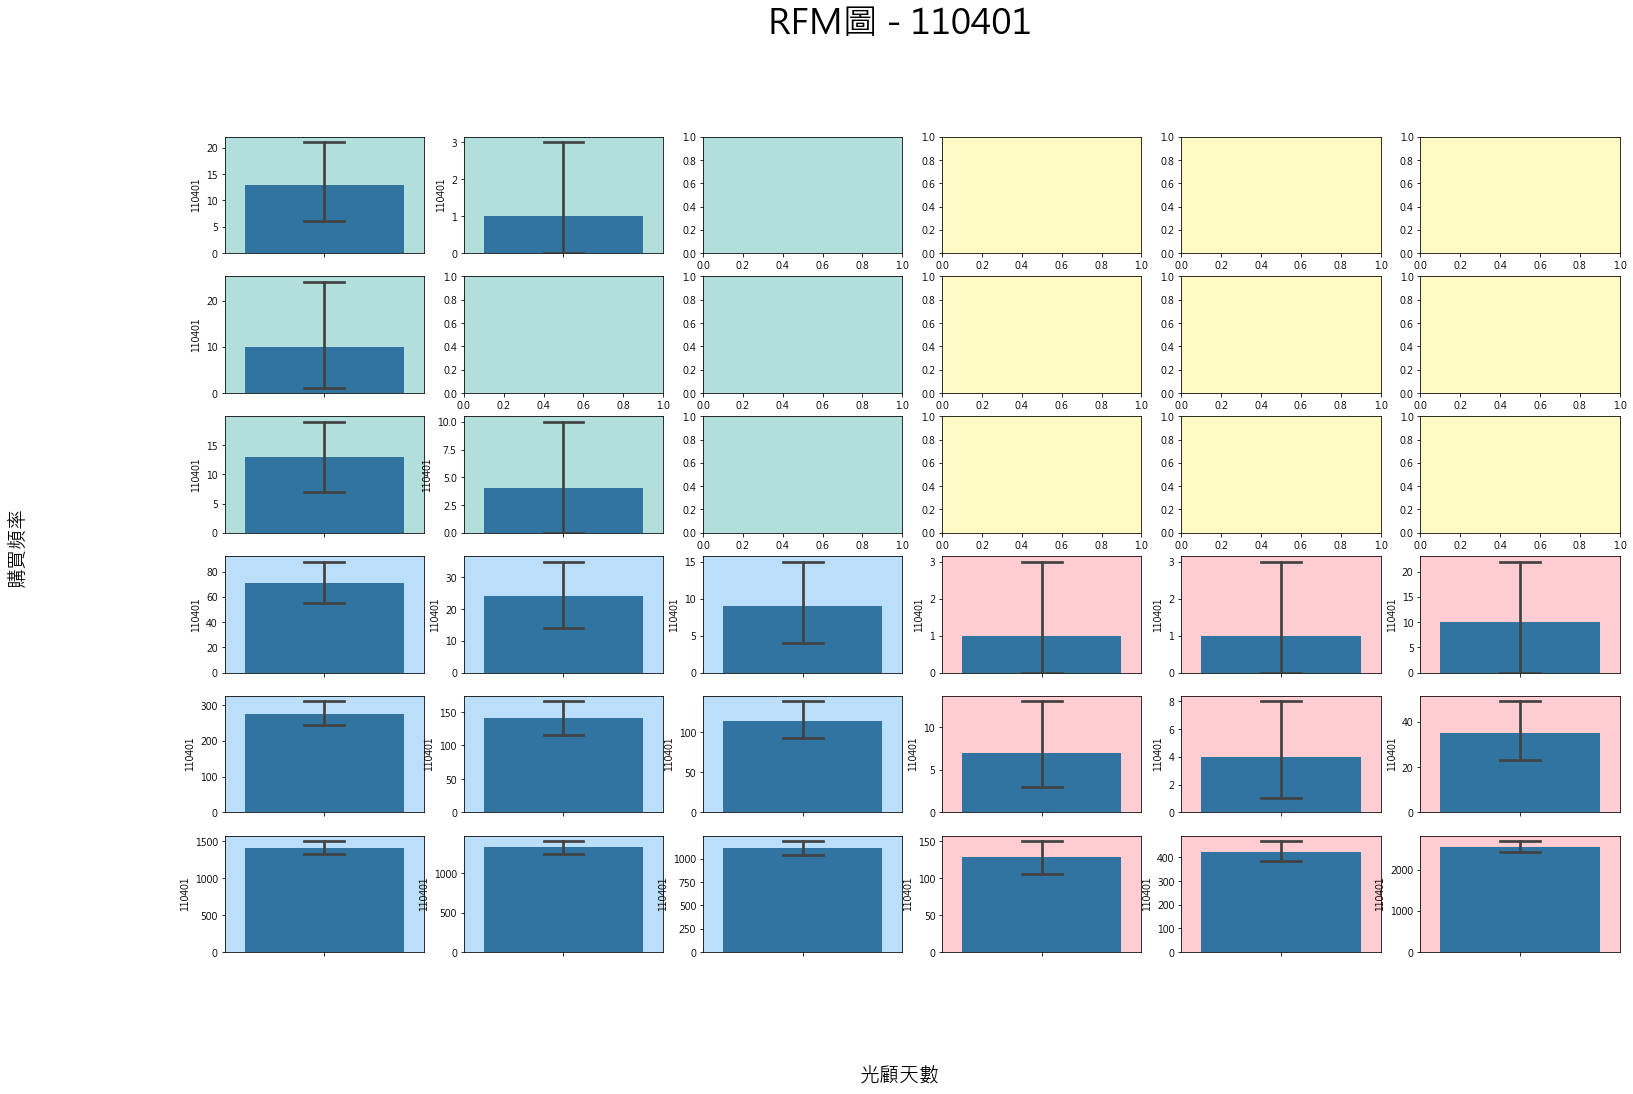

In [22]:
target_product = '110401'

#--- 繪圖
#先設定畫布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標
for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y=target_product, # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標

        ############### 四個區塊分顏色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #紅色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #藍色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #綠色
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - '+target_product, position=(.5,1), fontsize=35)
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20)
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20)
fig.show()

## 商品種類: 110411 來畫RFM

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/1709709610.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


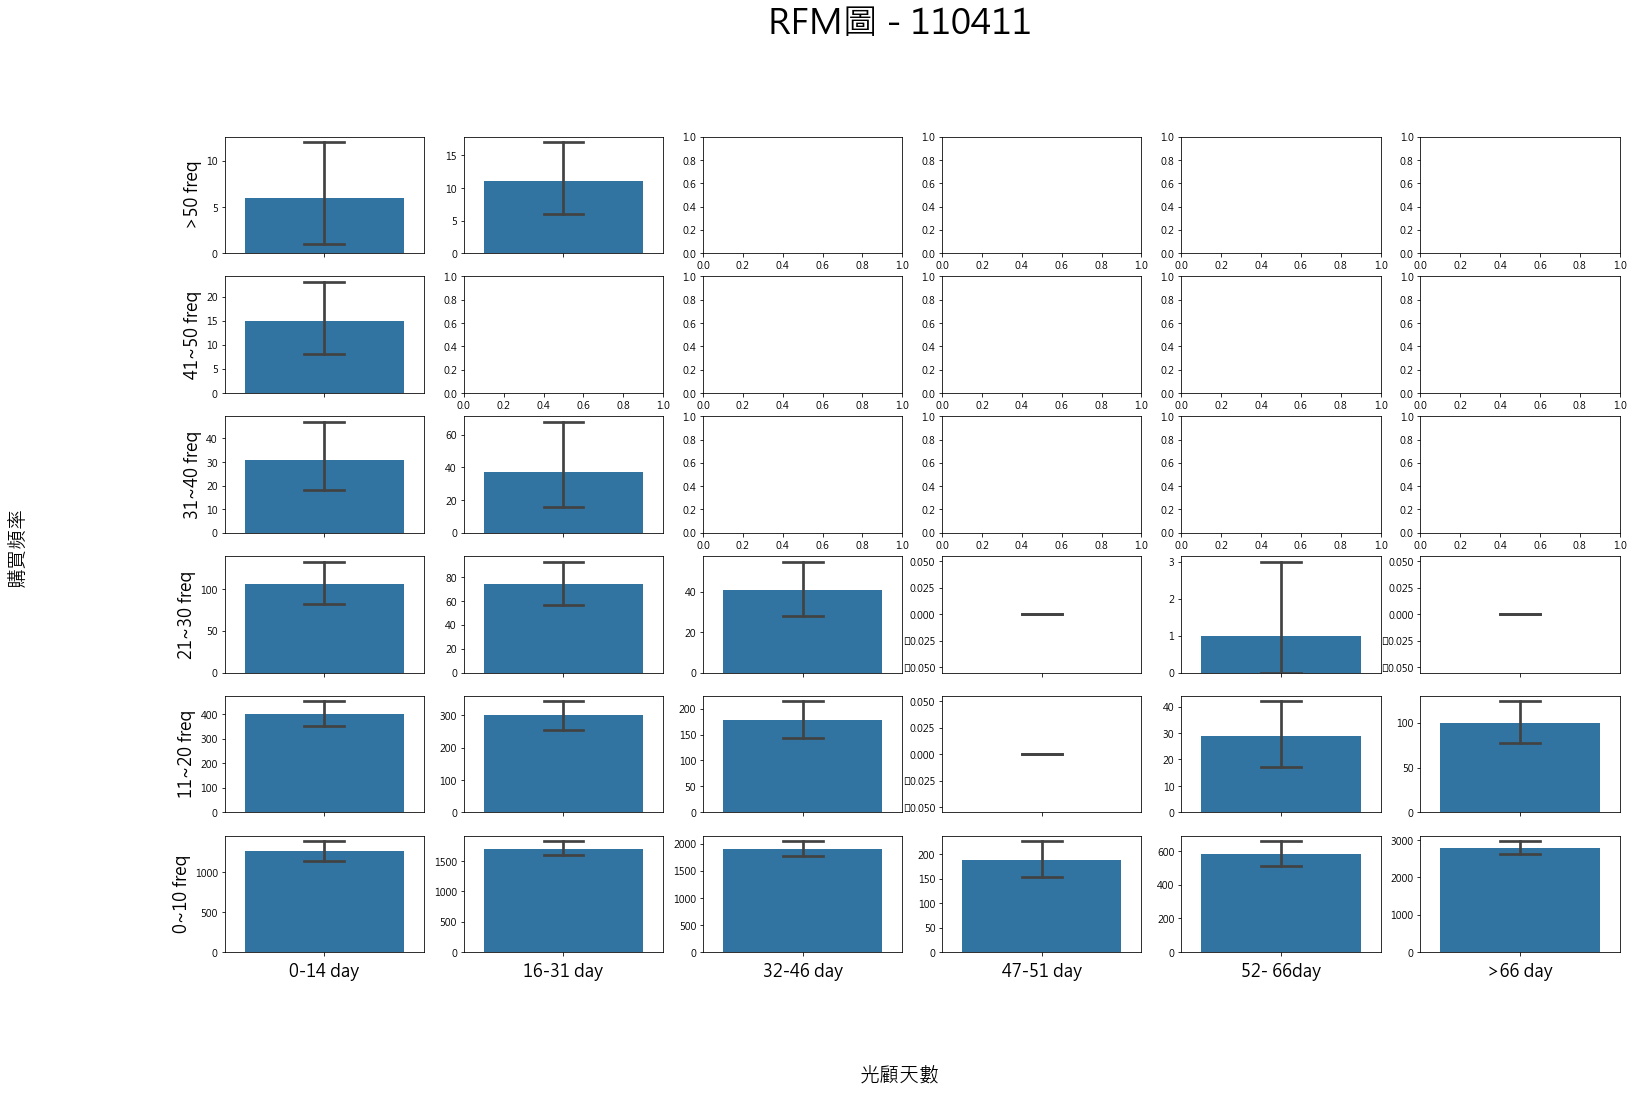

In [23]:
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標

for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y="110411", # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標
        ################ 畫X標籤 ################
        if i == '0~10 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)
            
        ############### 畫Y標籤 ################
        if j == '0-14 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - 110411', position=(.5,1), fontsize=35) # 設定標題
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20) # 設定X軸標題
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20) # 設定Y軸標題
fig.show()

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/1680777520.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


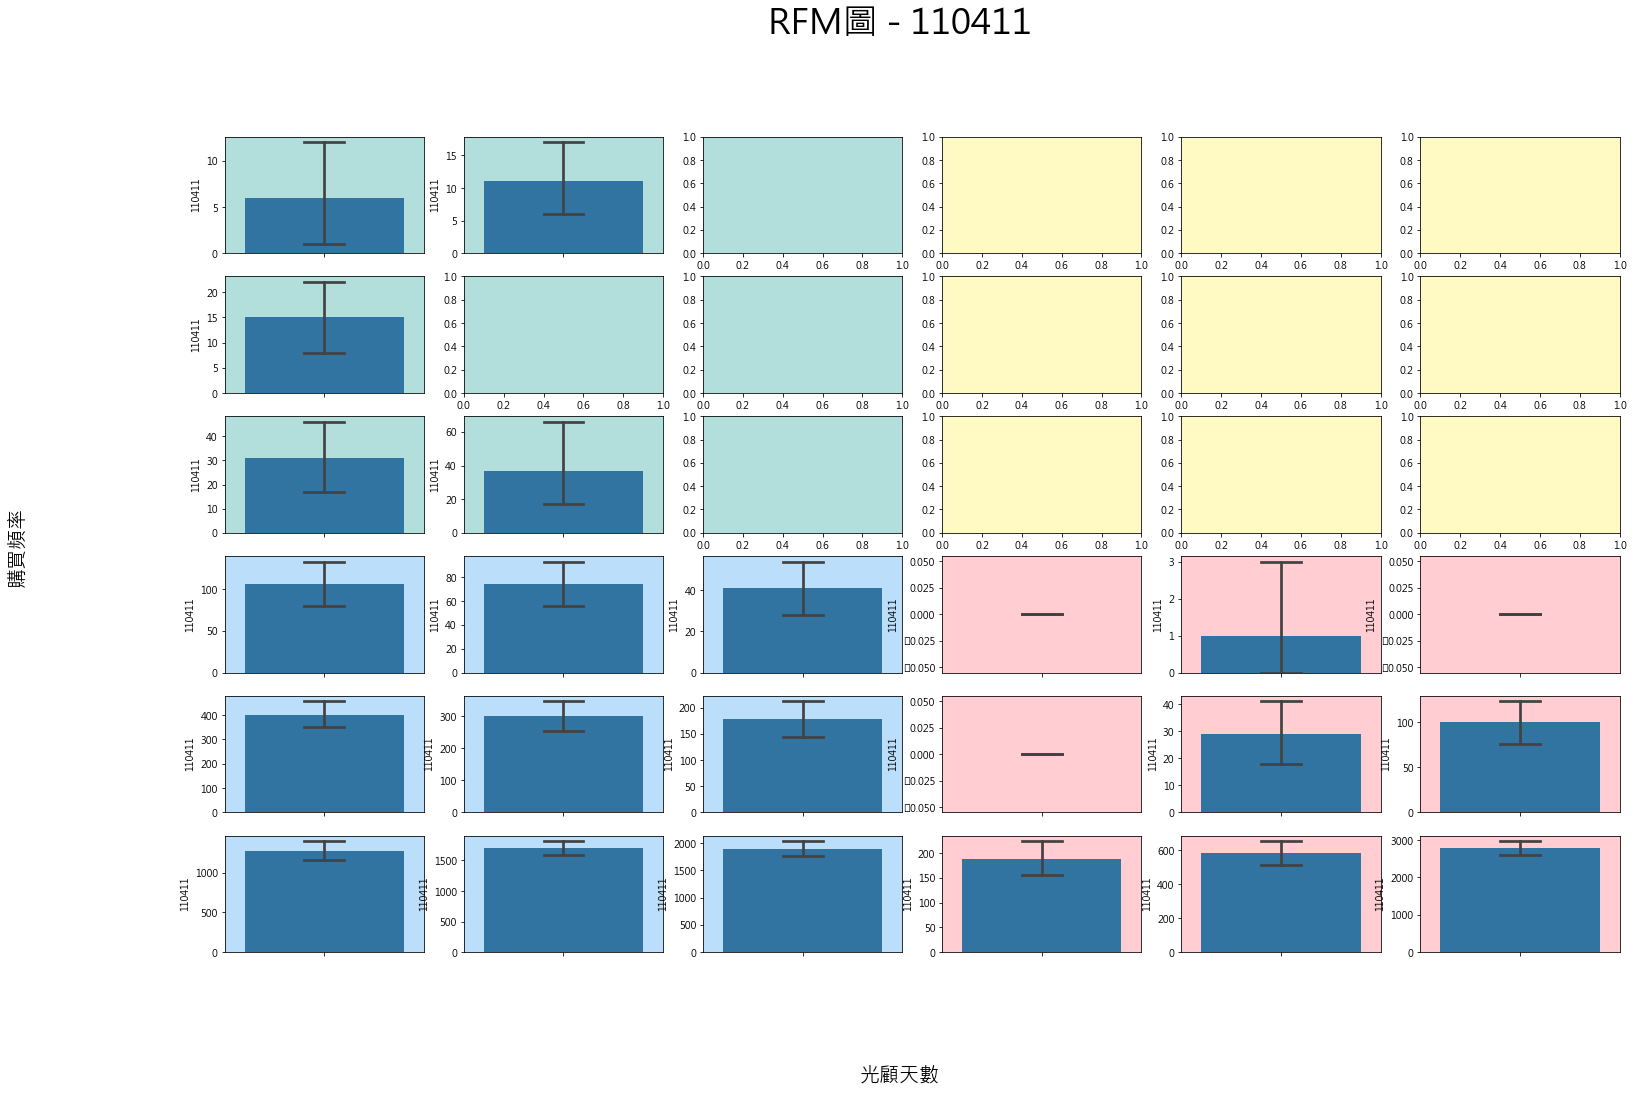

In [24]:
target_product = '110411'

#--- 繪圖
#先設定畫布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標
for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y=target_product, # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標

        ############### 四個區塊分顏色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #紅色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #藍色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #綠色
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - '+target_product, position=(.5,1), fontsize=35)
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20)
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20)
fig.show()

## 商品種類: 120103 來畫RFM

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/1014142952.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


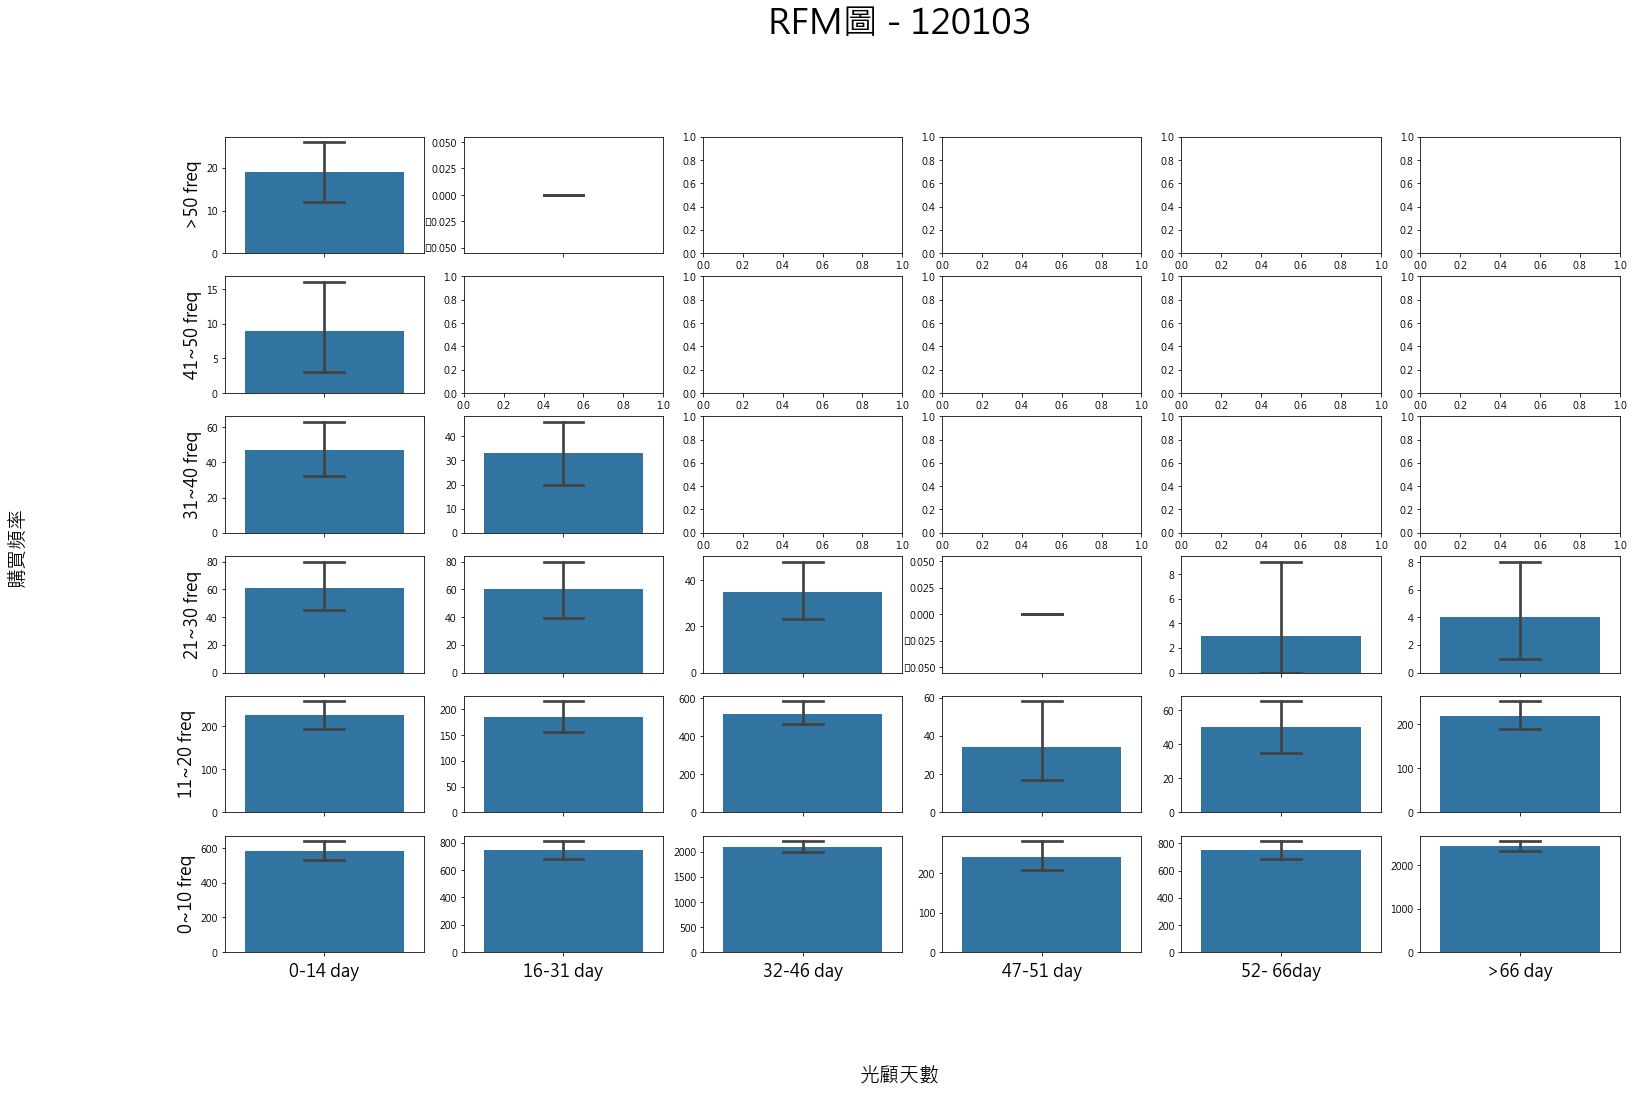

In [25]:
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標

for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y="120103", # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標
        ################ 畫X標籤 ################
        if i == '0~10 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)
            
        ############### 畫Y標籤 ################
        if j == '0-14 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - 120103', position=(.5,1), fontsize=35) # 設定標題
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20) # 設定X軸標題
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20) # 設定Y軸標題
fig.show()

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/3097832329.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


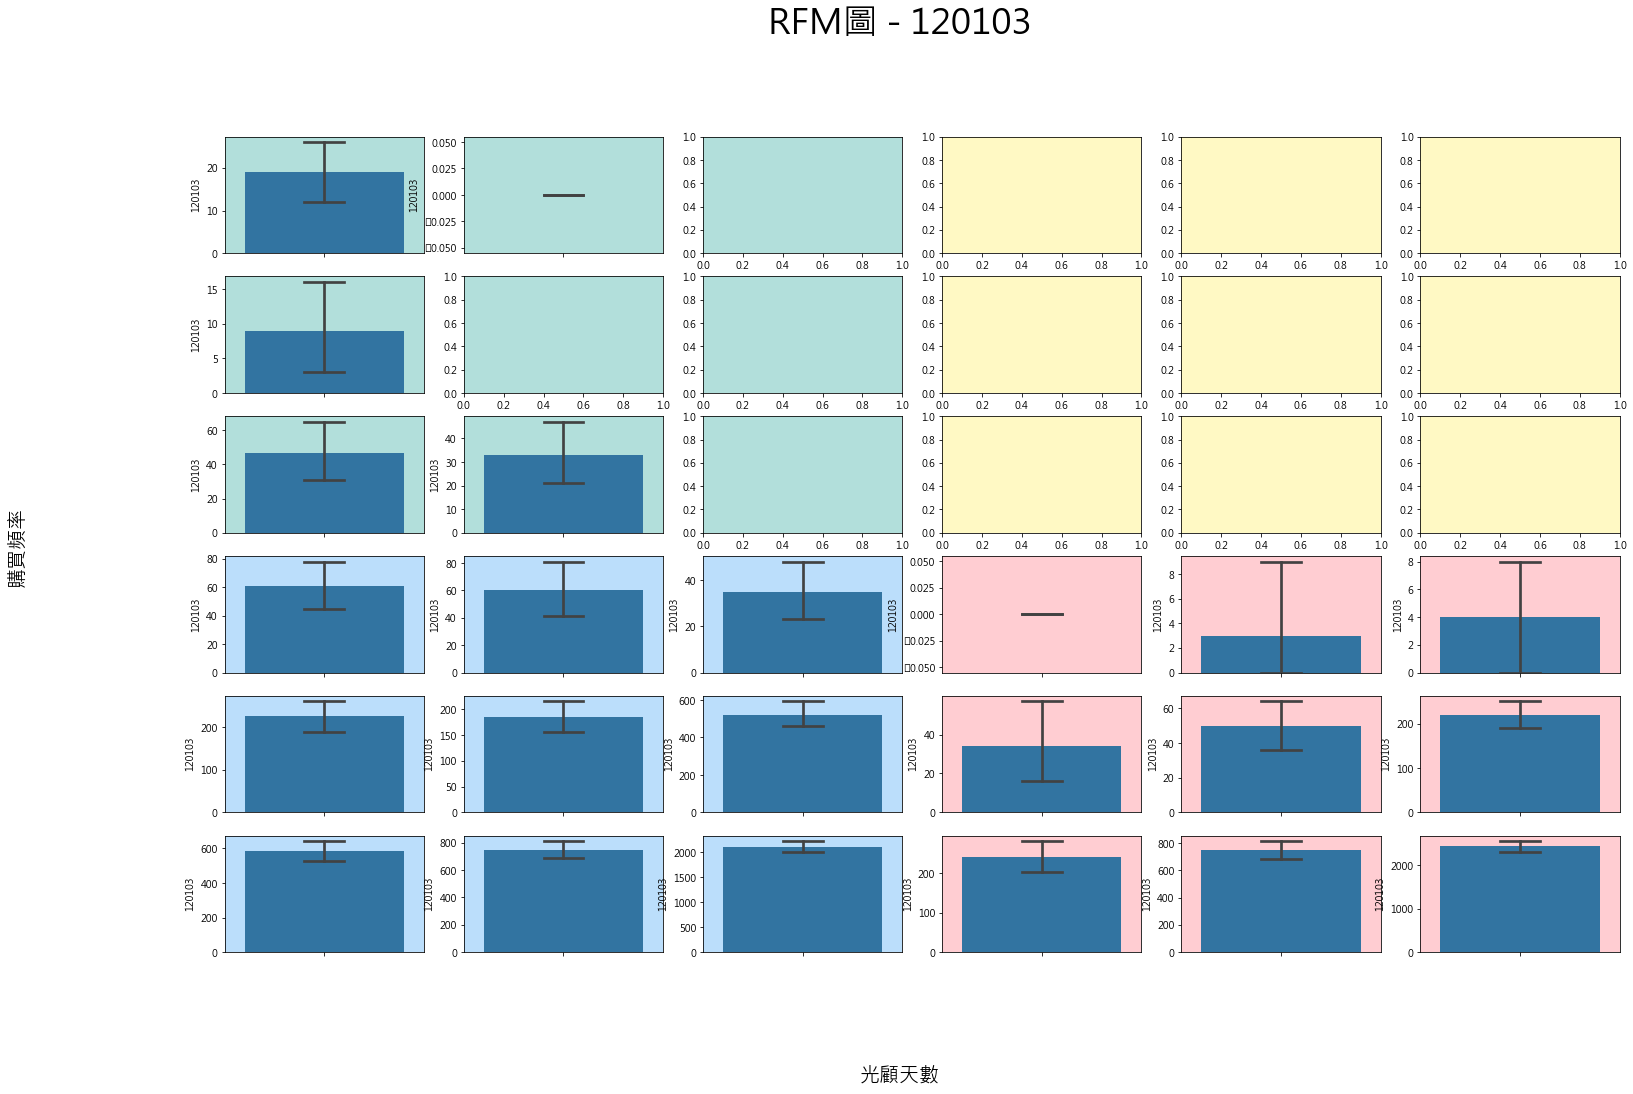

In [26]:
target_product = '120103'

#--- 繪圖
#先設定畫布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標
for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y=target_product, # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標

        ############### 四個區塊分顏色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #紅色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #藍色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #綠色
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - '+target_product, position=(.5,1), fontsize=35)
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20)
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20)
fig.show()

## 商品種類: 130206 來畫RFM

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/1608795078.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


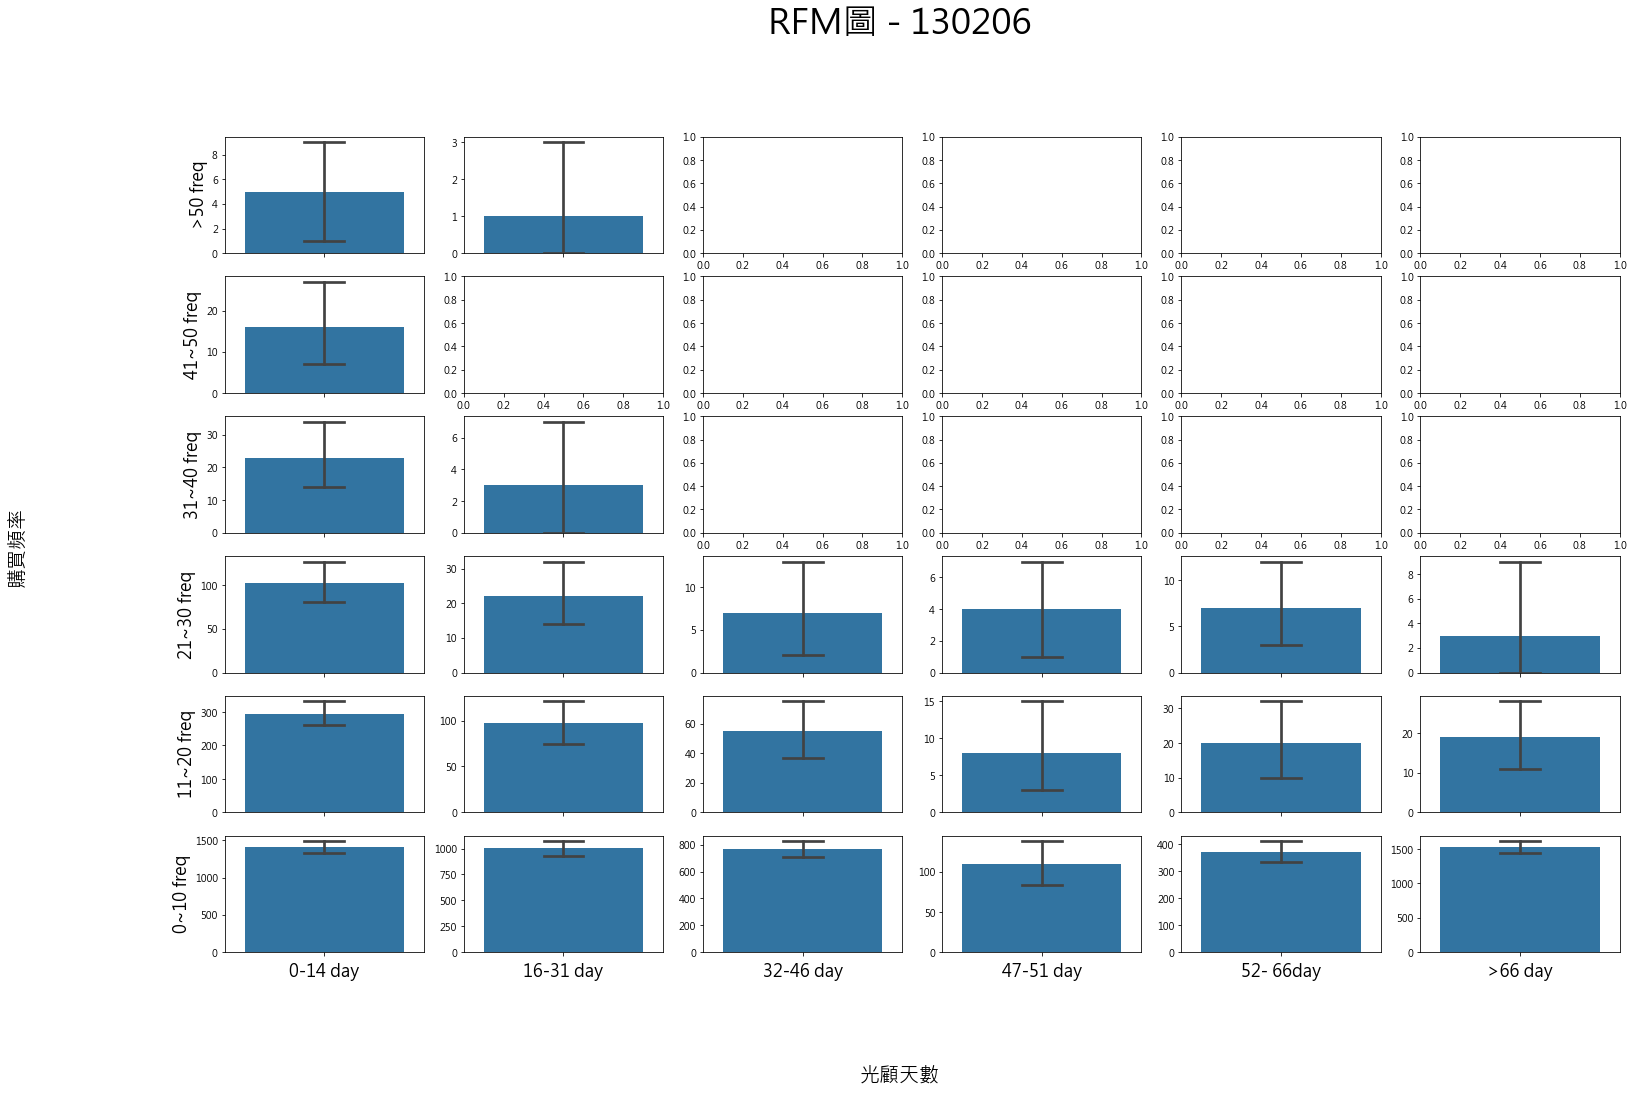

In [27]:
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標

for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y="130206", # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標
        ################ 畫X標籤 ################
        if i == '0~10 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)
            
        ############### 畫Y標籤 ################
        if j == '0-14 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - 130206', position=(.5,1), fontsize=35) # 設定標題
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20) # 設定X軸標題
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20) # 設定Y軸標題
fig.show()

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/212644844.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


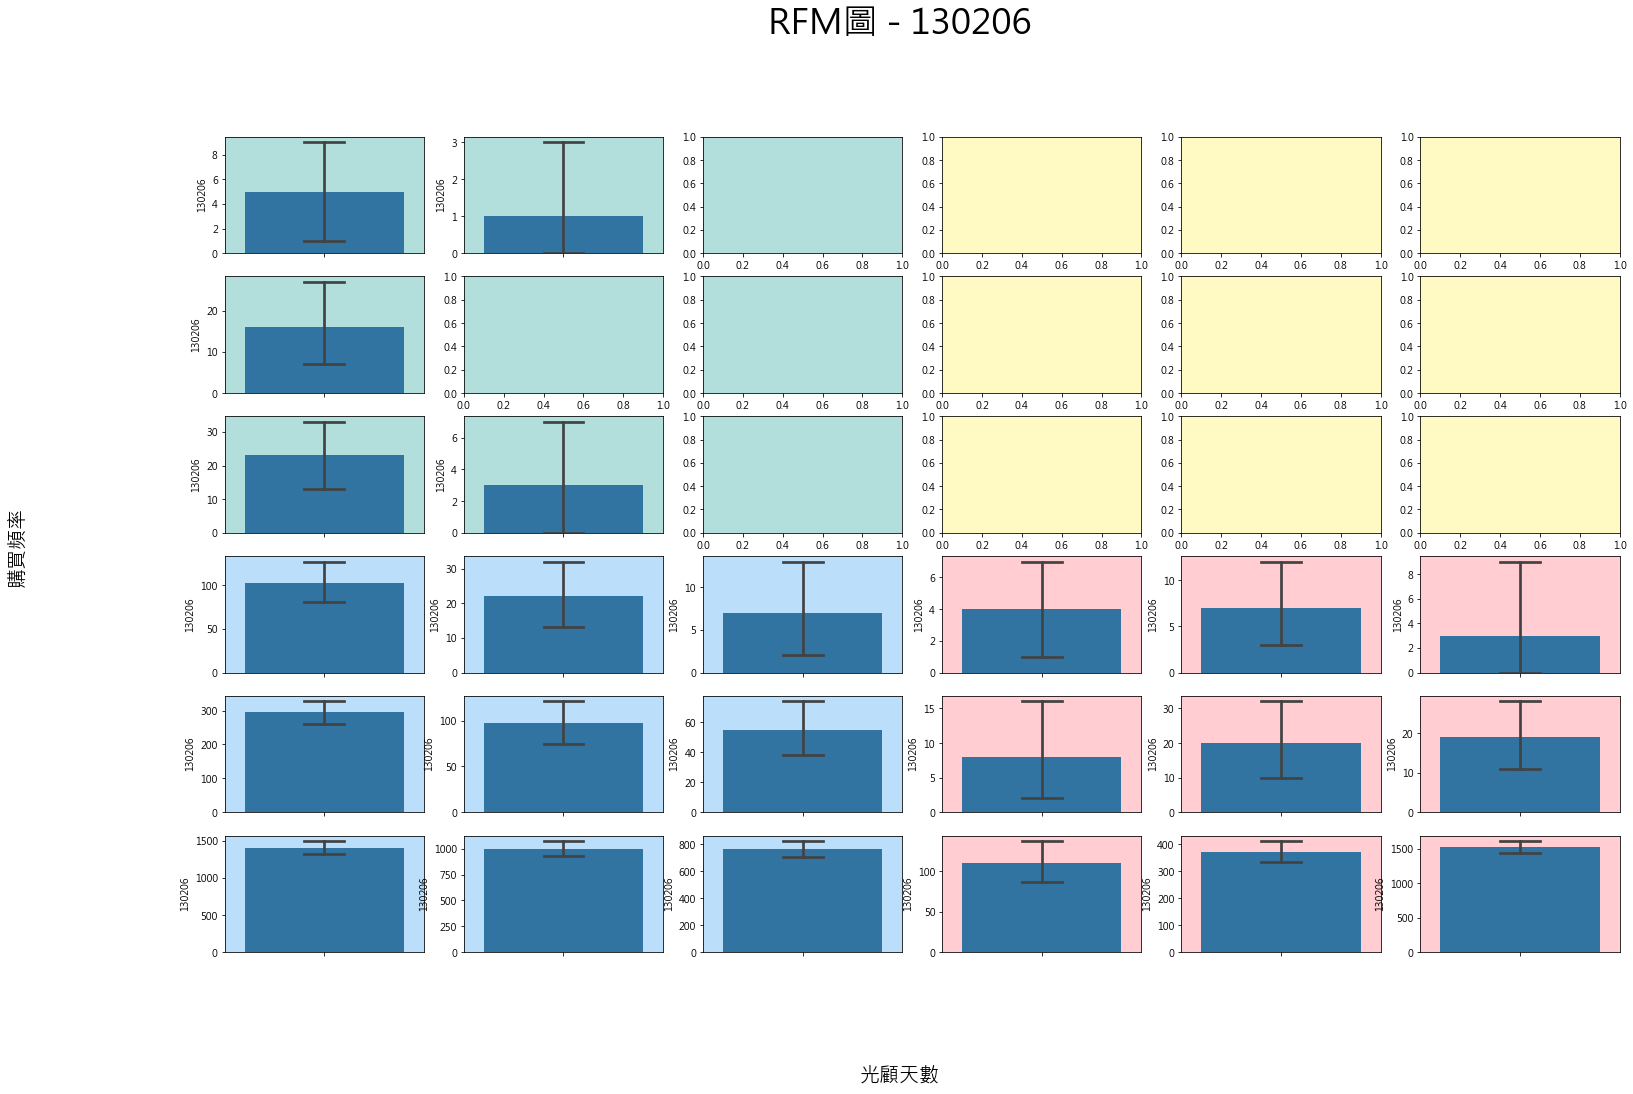

In [28]:
target_product = '130206'

#--- 繪圖
#先設定畫布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標
for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = purchase_list[(purchase_list['recency_cate']==j) & (purchase_list['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(y=target_product, # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        estimator=np.sum,
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標

        ############### 四個區塊分顏色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #紅色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #藍色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #綠色
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM圖 - '+target_product, position=(.5,1), fontsize=35)
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20)
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20)
fig.show()

## 綜合 RFM 產品分析 - 留下前三名就好 100205 & 120103 & 110401

In [29]:
df3 = pd.melt(purchase_list.drop(columns = ['ORDER_ID','Date','recency','frequency', '110411', '130206']), id_vars=['CUSTOMER_ID','customer','recency_cate','frequency_cate','AGE_GROUP', 'PIN_CODE'], var_name='types', value_name='values') 
df3['values'] = pd.to_numeric(df3['values'],errors='coerce')
df3 = df3.dropna()
df3

,CUSTOMER_ID,customer,recency_cate,frequency_cate,AGE_GROUP,PIN_CODE,types,values
0,1250,新顧客,16-31 day,0~10 freq,35-39,114,100205,1.0
1,1250,新顧客,16-31 day,0~10 freq,35-39,114,100205,1.0
2,1250,新顧客,16-31 day,0~10 freq,35-39,114,100205,2.0
3,1250,新顧客,16-31 day,0~10 freq,35-39,114,100205,0.0
4,1250,新顧客,16-31 day,0~10 freq,35-39,114,100205,2.0
...,...,...,...,...,...,...,...,...
99778,2179544,新顧客,0-14 day,0~10 freq,55-59,Others,120103,0.0
99779,2179605,新顧客,0-14 day,0~10 freq,25-29,Others,120103,0.0
99780,2179605,新顧客,0-14 day,0~10 freq,25-29,Others,120103,0.0
99781,2179605,新顧客,0-14 day,0~10 freq,25-29,Others,120103,0.0


/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/1930901697.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


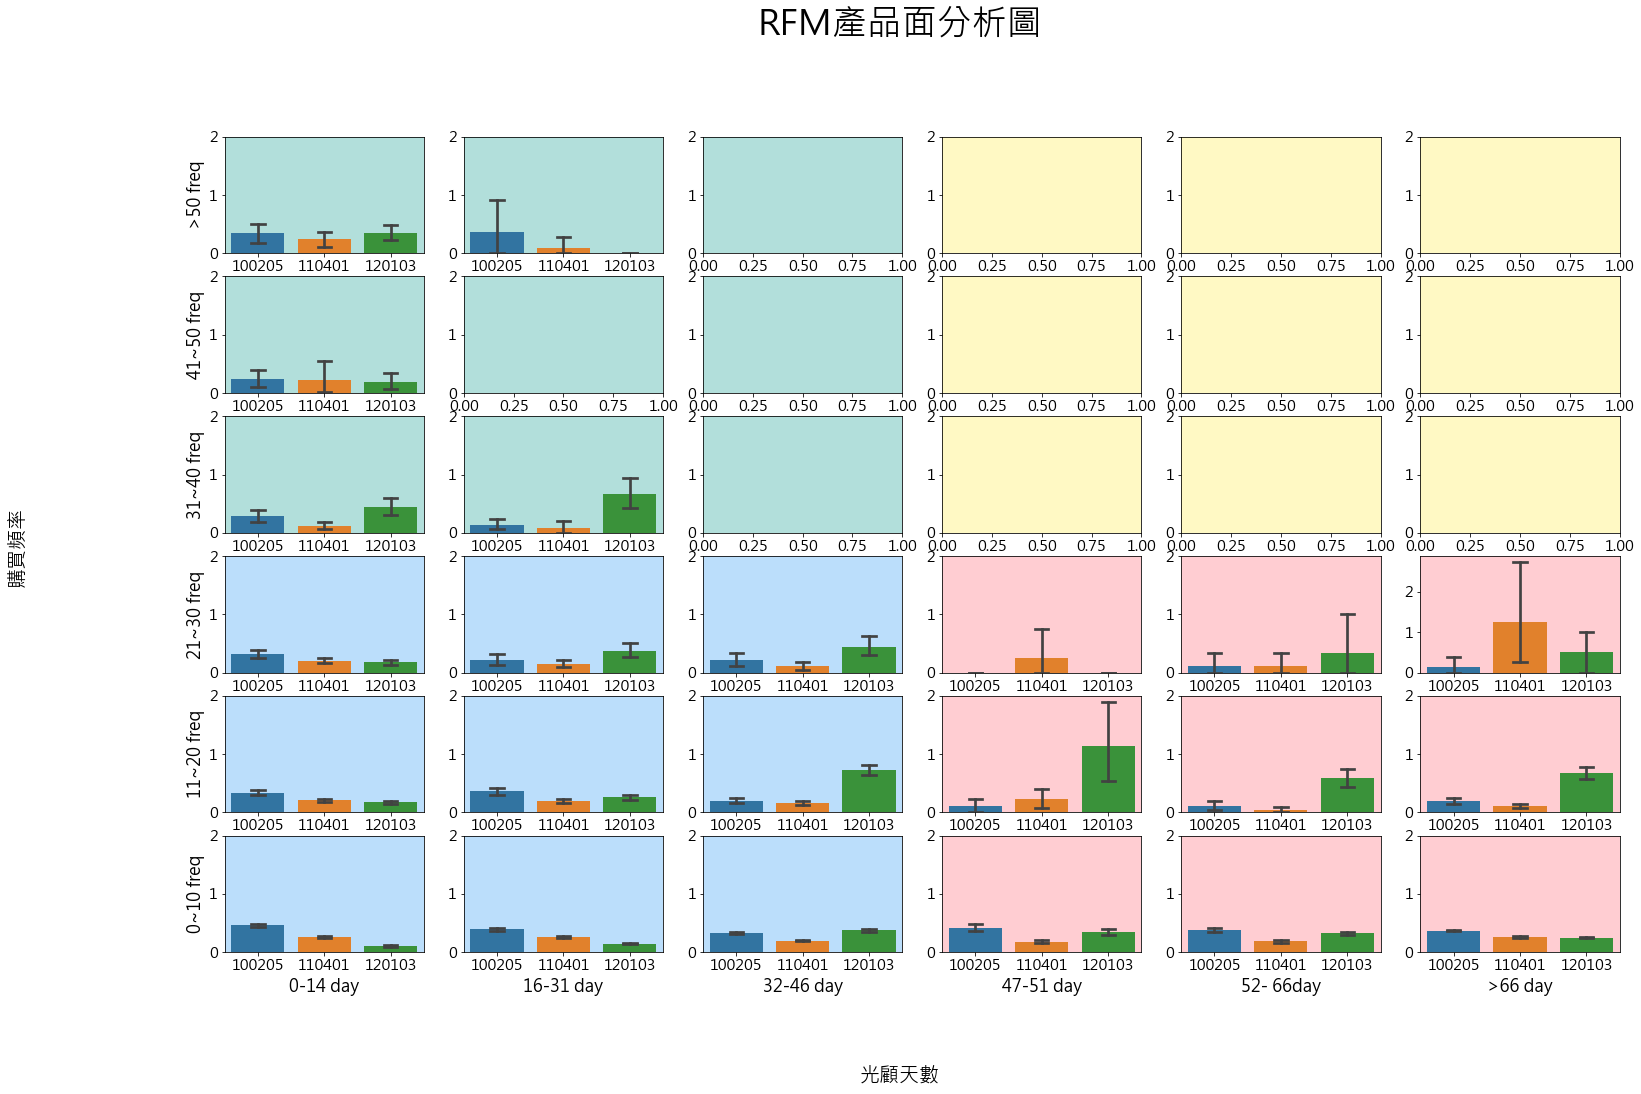

In [30]:
#--- 繪圖
#先設定畫布大小
fig, axes = plt.subplots(6, 6,figsize=(25,15))
countX = 0 # 畫布X軸座標
for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = df3[(df3['recency_cate']==j) & (df3['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            # 以下為單一小圖表的設定
            sns.barplot(x="types", # 小圖表X資料來源欄位
                        y="values", # 小圖表Y資料來源欄位
                        data=data, #來源資料表
                        capsize=.2, # 最高點最低點的大小
                        ax=axes[countX, countY]) # 小圖表座標
        # ################ 畫X標籤 ################
        if i == '0~10 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)
            
        ############### 畫Y標籤 ################
        if j == '0-14 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')
            
            
        ################ 將水、牛奶、香蕉的字變大 ################
        axes[countX][countY].tick_params(labelsize=15)
        ############### 使所有數據的尺碼相同 ################
        axes[countX][countY].set_yticks(range(0,3,1))
        
        
        ############### 四個區塊分顏色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #紅色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #藍色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #綠色
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM產品面分析圖', position=(.5,1), fontsize=35) # 設定標題
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20) # 設定X軸標題
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20) # 設定Y軸標題
fig.show()

## RFM 市場面分析 - 區域影響 - 以前三名產品為例

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/891084818.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


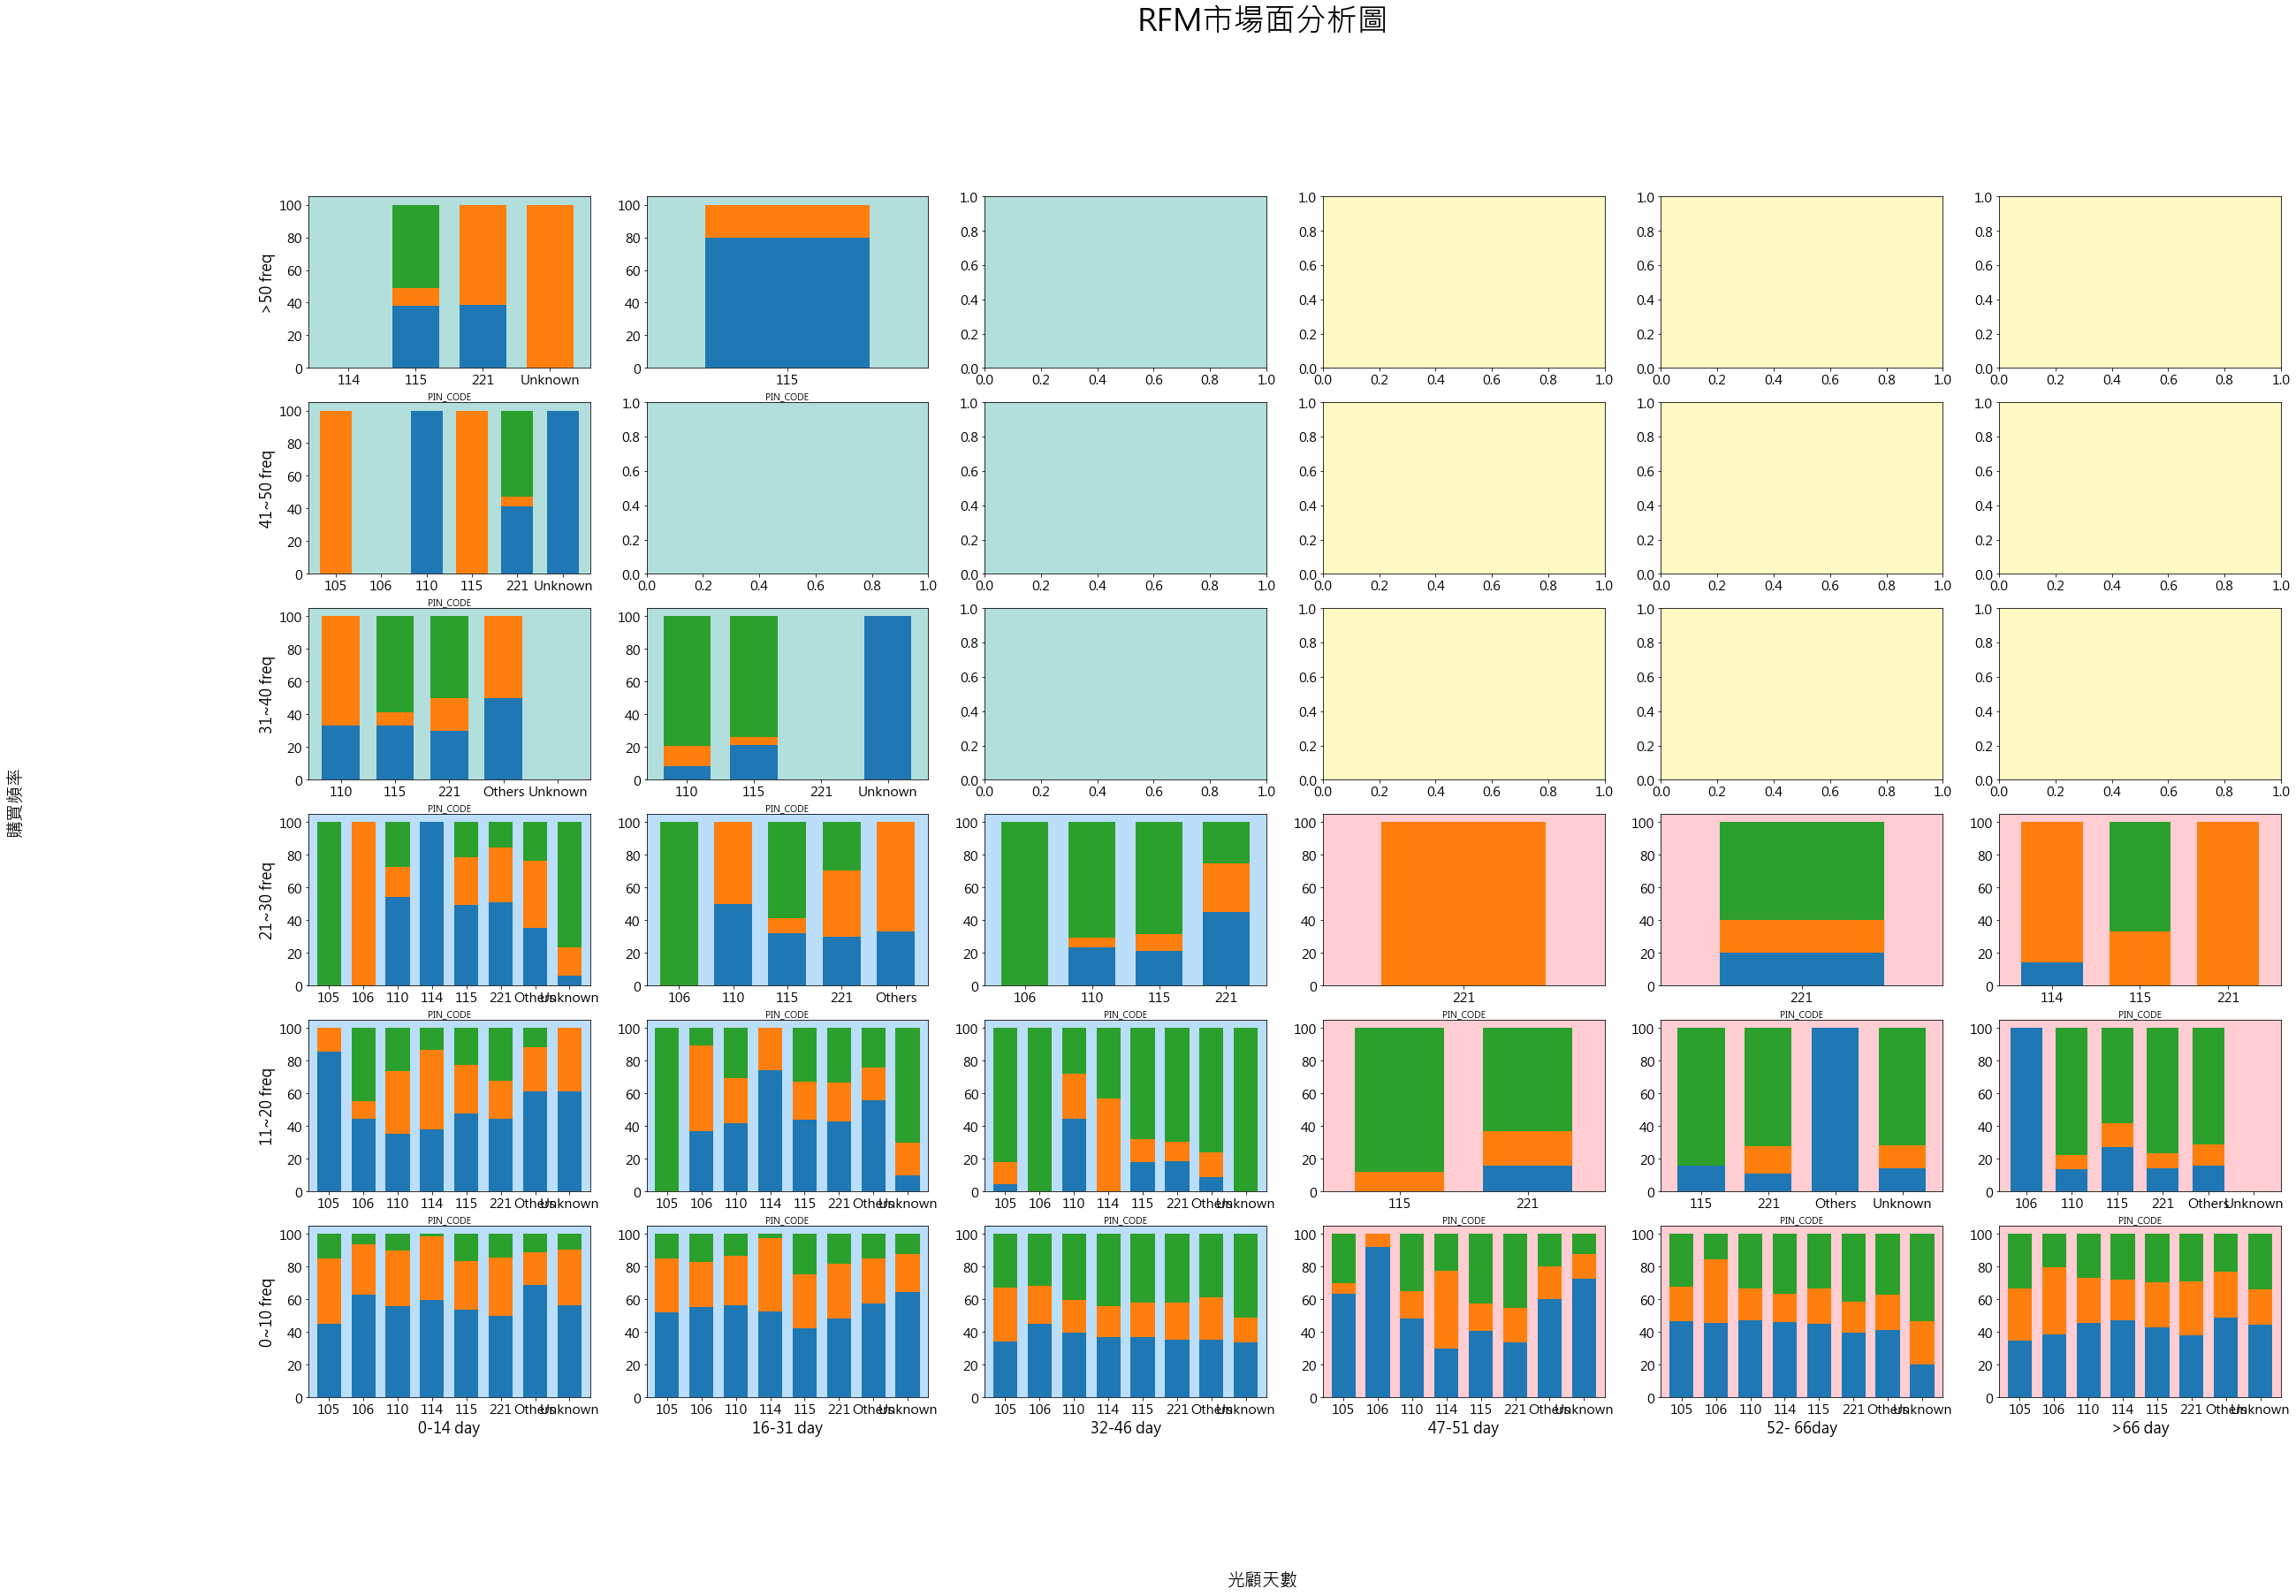

In [31]:
#--- 繪圖
#先設定畫布大小
fig, axes = plt.subplots(6, 6,figsize=(40,25))
countX = 0 # 畫布X軸座標
for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = df3[(df3['recency_cate']==j) & (df3['frequency_cate']==i)]
        if data.shape[0] != 0: # 檢查這個方格有沒有數據
            data = data[['PIN_CODE','types','values']].groupby(['types','PIN_CODE']).sum()
            data =data.groupby(level=1).apply(lambda x:100 * x / float(x.sum())) # 將其數量換成百分比
            data = data.add_suffix('').reset_index() #將三圍度改為二圍度
            data=data.pivot('PIN_CODE', 'types', 'values') # XY軸交換表示
            
            # 以下為單一小圖表的設定
            ax = data.plot.bar(stacked=True, # 設定為堆疊
                              width=0.7,# 柱子的寬度
                              legend = False, 
                              ax =axes[countX, countY] , # 小圖表座標
                              rot=0) #小圖示的標籤旋轉 
            
        ################ 畫X標籤 ################
        if i == '0~10 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)
            
        ############### 畫Y標籤 ################
        if j == '0-14 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')
            
            
        ################ 將水、牛奶、香蕉的字變大 ################
        axes[countX][countY].tick_params(labelsize=15)
        
        
        ############### 四個區塊分顏色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #紅色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #藍色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #綠色
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM市場面分析圖', position=(.5,1), fontsize=35) # 設定標題
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20) # 設定X軸標題
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20) # 設定Y軸標題
fig.show()


In [32]:
## 每個區域對三個產品的消費次數比例
data

types,100205,110401,120103
PIN_CODE,,,
105,34.716981,32.075472,33.207547
106,38.679245,40.880503,20.440252
110,45.454545,27.852998,26.692456
114,47.395833,24.479167,28.125000
115,42.685759,27.515480,29.798762
221,38.153724,32.686212,29.160063
Others,48.582231,28.166352,23.251418
Unknown,44.366197,21.830986,33.802817


/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/3360821742.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


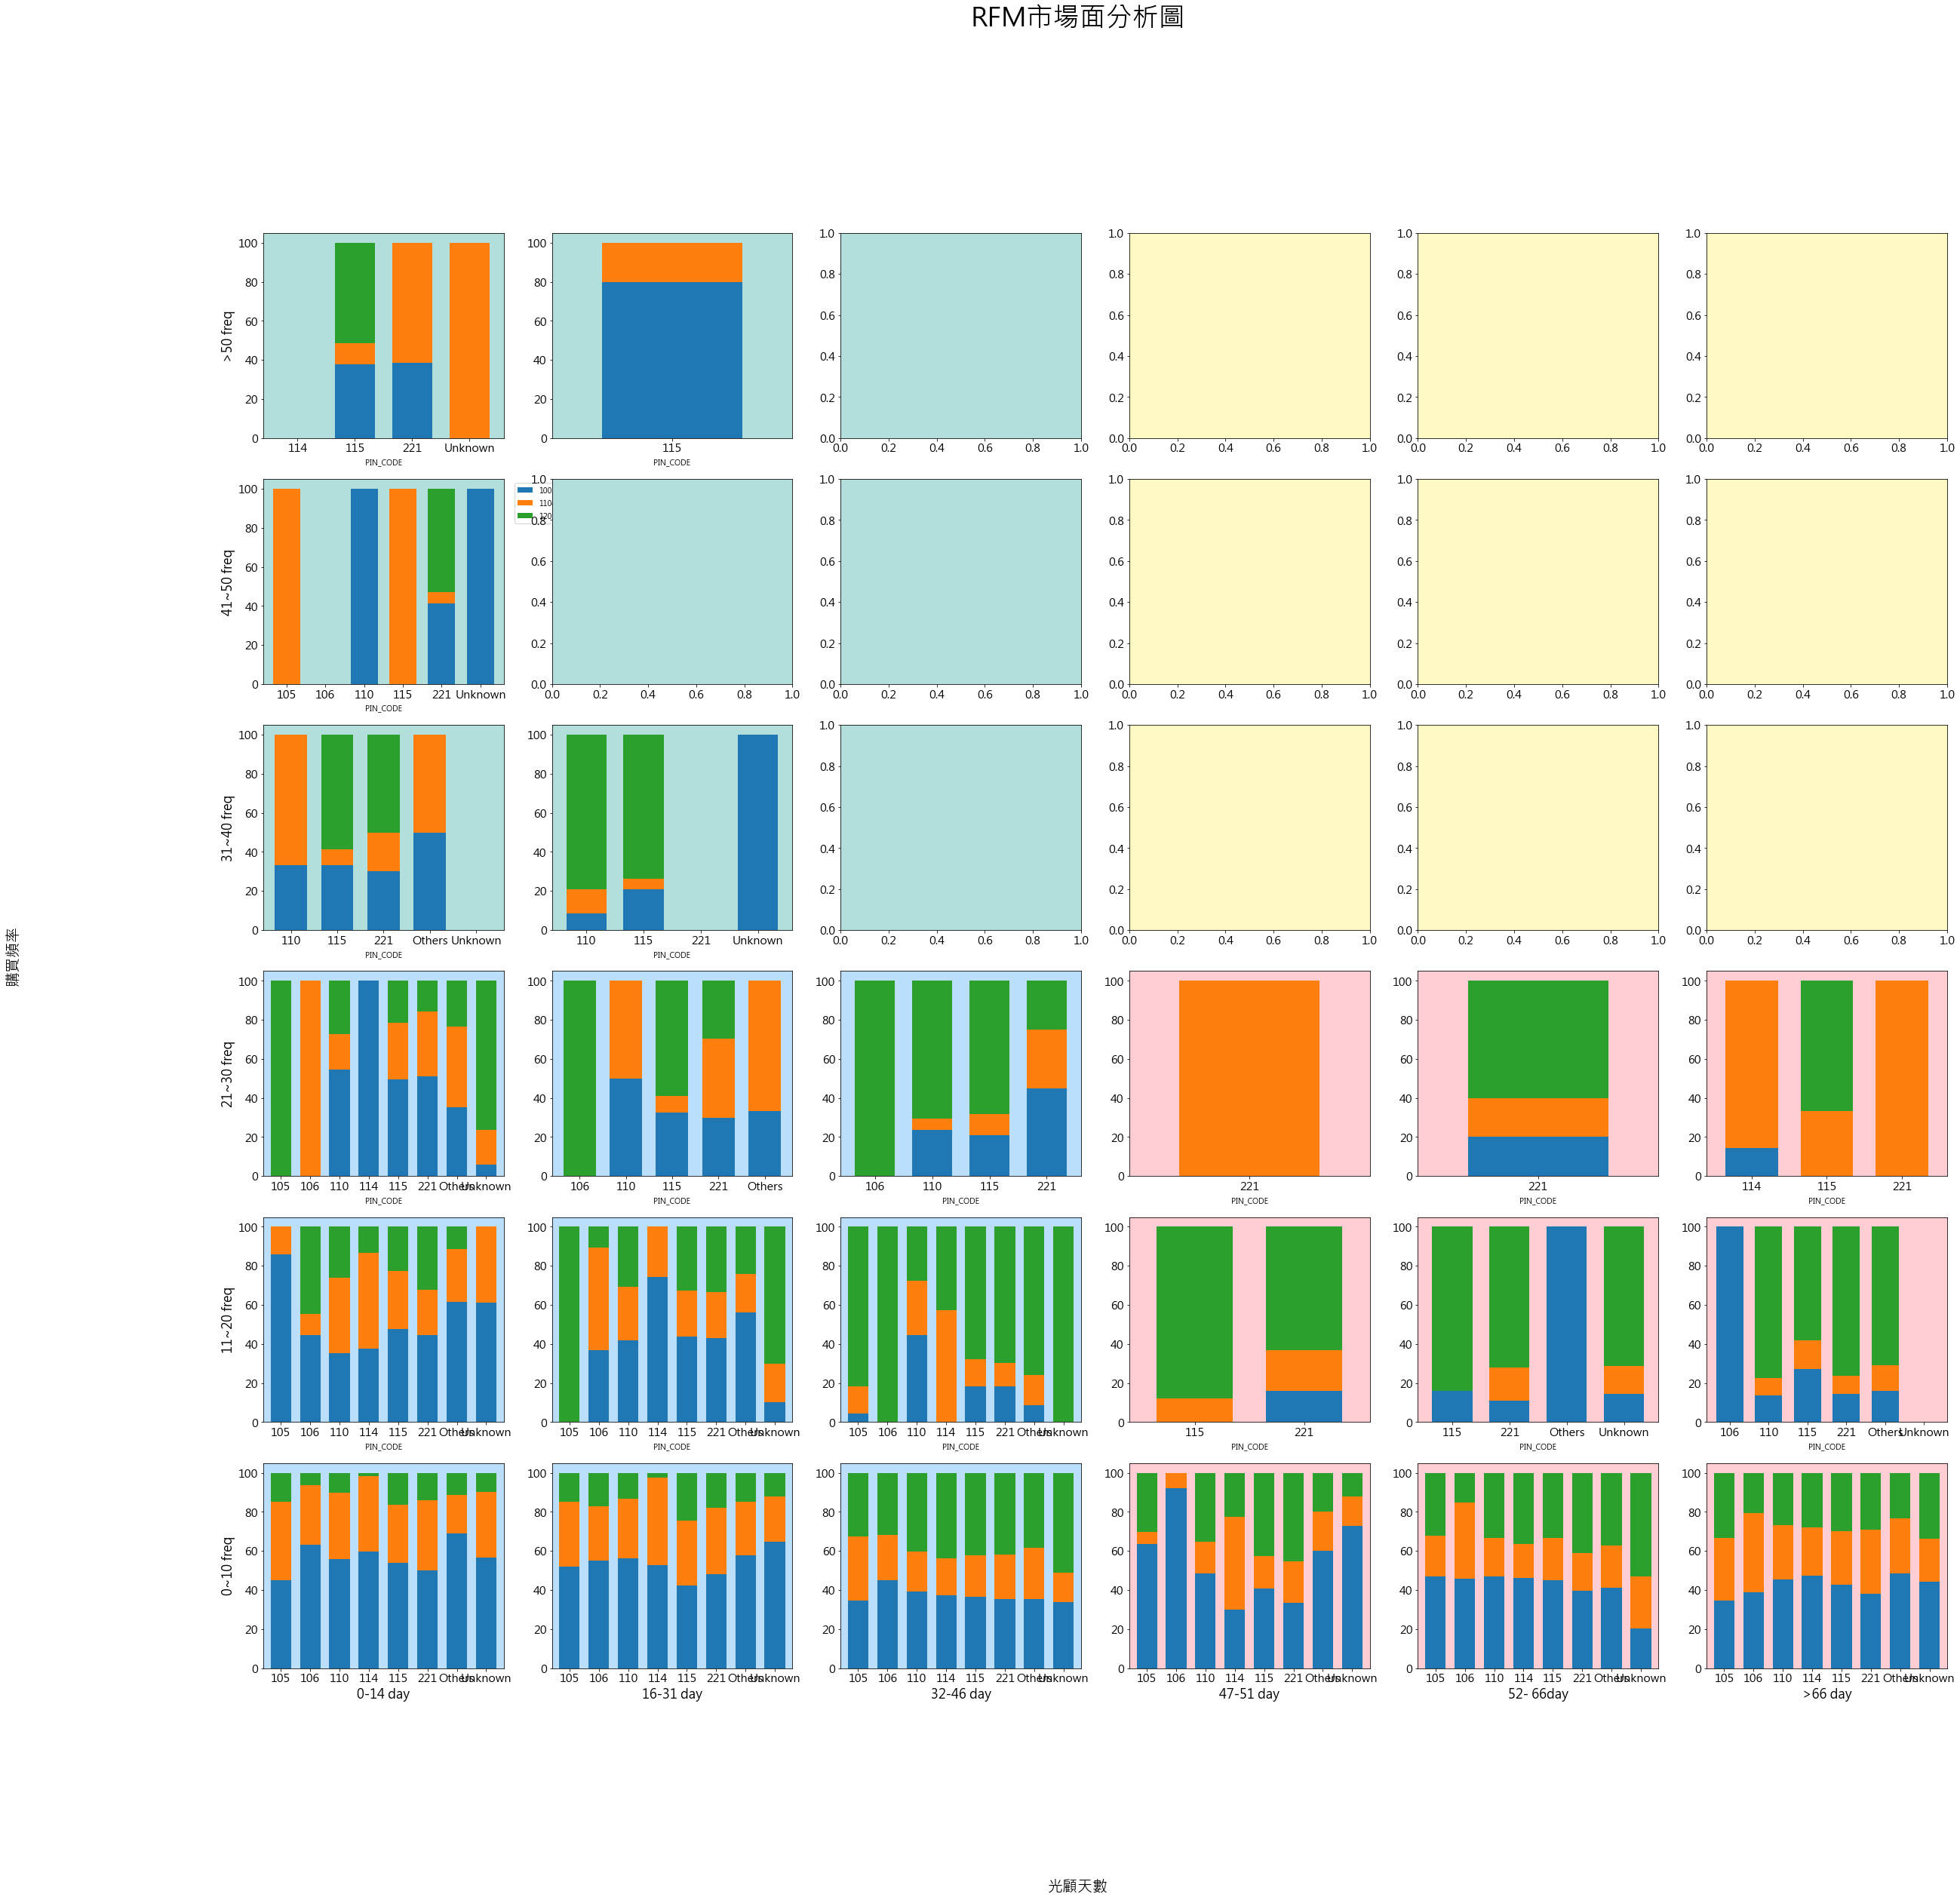

In [33]:
## 將圖例隱藏，剩一個
#--- 繪圖
#先設定畫布大小
fig, axes = plt.subplots(6, 6,figsize=(40,35))
countX = 0 # 畫布X軸座標
for i in frequency_label[::-1]: # 由於axes畫布排列的關係，頻率必須要反著放
    countY = 0 # 畫布Y軸座標
    for j in recency_label: # 近因
        data = df3[(df3['recency_cate']==j) & (df3['frequency_cate']==i)]
        if data.shape[0] != 0: 
            data = data[['PIN_CODE','types','values']].groupby(['types','PIN_CODE']).sum()
            data =data.groupby(level=1).apply(lambda x:100 * x / float(x.sum())) # 將其數量換成百分比
            data = data.add_suffix('').reset_index() #將三圍度改為二圍度
            data=data.pivot('PIN_CODE', 'types', 'values') # XY軸交換表示
            
            # 以下為單一小圖表的設定
            ax = data.plot.bar(stacked=True, # 設定為堆疊
                              width=0.7,# 柱子的寬度
                              legend = False, 
                              ax =axes[countX, countY] , # 小圖表座標
                              rot=0) #小圖示的標籤旋轉
            
        ################ 設定圖例 ################
        if (i == '41~50 freq') and (j == '>66 day'):
            ax.legend(bbox_to_anchor=(1.03, 1), loc=2, fontsize =10) #設定圖例  
            
        ################ 畫X標籤 ################
        if i == '0~10 freq':
            axes[countX][countY].set_xlabel(j, fontsize=17)
            
        ############### 畫Y標籤 ################
        if j == '0-14 day':
            axes[countX][countY].set_ylabel( frequency_label[::-1][countX], fontsize=17)
        else:
            axes[countX][countY].set_ylabel('')
            
            
        ################ 將水、牛奶、香蕉的字變大 ################
        axes[countX][countY].tick_params(labelsize=15)
        
        
        ############### 四個區塊分顏色 ################
        if countY > 2 and countX > 2:
            axes[countX][countY].set(facecolor="#ffcdd2") #紅色
        elif countY > 2 and countX < 3:
            axes[countX][countY].set(facecolor="#FFF9C4") #黃色
        elif countY < 3 and countX > 2:
            axes[countX][countY].set(facecolor="#BBDEFB") #藍色
        else:
            axes[countX][countY].set(facecolor="#B2DFDB") #綠色
            
        countY += 1 
    countX += 1 
fig.suptitle('RFM市場面分析圖', position=(.5,1), fontsize=35) # 設定標題
fig.text(0.5, 0.01, '光顧天數', ha='center', va='center', fontsize=20) # 設定X軸標題
fig.text(0.01, 0.5, '購買頻率', ha='center', va='center', rotation='vertical', fontsize=20) # 設定Y軸標題
fig.show()

## RFM 顧客回購面分析 - 前五名商品

CAI: 顧客活躍度
CAI > 0: 代表活躍
CAI < 0: 代表不活躍

In [34]:
theOS = list(platform.uname())[0]
if theOS == 'Windows':
    theOS = '\\'
    theEncode = 'utf-8-sig'
else:
    theOS = '/'
    theEncode = 'utf-8'

df = pd.read_csv('../data/ta_feng_all_months_merged.csv')

## 時間格式轉換
df['Date'] = pd.to_datetime(df['TRANSACTION_DT'])
## 增加一筆用來計算頻率的欄位
df['count'] = 1
## 創建訂單ID
df['ORDER_ID'] = df.index

product_five = df.groupby('PRODUCT_SUBCLASS')['count'].sum().sort_values(ascending = False)[:5]
new_df = df[df['PRODUCT_SUBCLASS'].isin(product_five.index)]

purchase_list = new_df.pivot_table(index = ['CUSTOMER_ID', 'ORDER_ID', 'PIN_CODE', 'Date', 'AGE_GROUP'],
                                    columns='PRODUCT_SUBCLASS',
                                    aggfunc=sum,
                                    values='AMOUNT'
                                    ).fillna(0).reset_index()
purchase_list['frequency'] = 1

frequency = purchase_list.groupby("CUSTOMER_ID",
as_index= False)['frequency'].sum()

del purchase_list['frequency']


# 合併 frequency 
purchase_list =purchase_list.merge(frequency, # 即將合併上去的資料表
                                   on = ['CUSTOMER_ID'] # 兩表間連接的key
                                   ,how='inner') # 合併的方式

theToday = purchase_list['Date'].max()
purchase_list['recency'] =( theToday - purchase_list['Date'] ).astype(str)
purchase_list
purchase_list['recency'] = purchase_list['recency'].str.replace('days.*',
                                                                  '',
                                                                  regex = True)
purchase_list['recency'] = purchase_list['recency'].astype(int)
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,ORDER_ID,PIN_CODE,Date,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency
0,1250,623618,114,2001-02-10,35-39,1.0,0.0,0.0,0.0,0.0,6,18
1,1250,624360,114,2001-02-10,35-39,1.0,0.0,0.0,0.0,0.0,6,18
2,1250,625617,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18
3,1250,626748,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18
4,1250,628013,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18
...,...,...,...,...,...,...,...,...,...,...,...,...
71323,2179544,813198,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,1.0,3,0
71324,2179605,802147,Others,2001-02-28,25-29,1.0,0.0,0.0,0.0,0.0,4,0
71325,2179605,803703,Others,2001-02-28,25-29,0.0,0.0,0.0,0.0,1.0,4,0
71326,2179605,805396,Others,2001-02-28,25-29,2.0,0.0,0.0,0.0,0.0,4,0


In [35]:
## 計算顧客購買間隔時間
purchase_list['interval'] = purchase_list.groupby("CUSTOMER_ID", #分類條件
                                  as_index = True # 分類條件是否要取代Index
                                  )['Date'].diff()
#刪除第一次來本店的資料 (因為要算區間，第一筆沒有用，和只來一次的顧客就會被刪掉)
purchase_list.dropna(inplace = True)
# 將時間資料轉成字串
purchase_list['interval'] = purchase_list['interval'].astype(str)
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,ORDER_ID,PIN_CODE,Date,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency,interval
1,1250,624360,114,2001-02-10,35-39,1.0,0.0,0.0,0.0,0.0,6,18,0 days
2,1250,625617,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0 days
3,1250,626748,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0 days
4,1250,628013,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0 days
5,1250,628844,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71322,2179544,813197,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,2.0,3,0,0 days
71323,2179544,813198,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,1.0,3,0,0 days
71325,2179605,803703,Others,2001-02-28,25-29,0.0,0.0,0.0,0.0,1.0,4,0,0 days
71326,2179605,805396,Others,2001-02-28,25-29,2.0,0.0,0.0,0.0,0.0,4,0,0 days


In [36]:
#將欄位中的days去除
purchase_list['interval'] = purchase_list['interval'].str.replace('days.*', '').astype(int)
purchase_list

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/753511120.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  purchase_list['interval'] = purchase_list['interval'].str.replace('days.*', '').astype(int)


PRODUCT_SUBCLASS,CUSTOMER_ID,ORDER_ID,PIN_CODE,Date,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency,interval
1,1250,624360,114,2001-02-10,35-39,1.0,0.0,0.0,0.0,0.0,6,18,0
2,1250,625617,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0
3,1250,626748,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0
4,1250,628013,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0
5,1250,628844,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71322,2179544,813197,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,2.0,3,0,0
71323,2179544,813198,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,1.0,3,0,0
71325,2179605,803703,Others,2001-02-28,25-29,0.0,0.0,0.0,0.0,1.0,4,0,0
71326,2179605,805396,Others,2001-02-28,25-29,2.0,0.0,0.0,0.0,0.0,4,0,0


In [37]:
## 計算第幾次來本店消費
purchase_list['cumsum'] = 1
purchase_list['cumsum'] = purchase_list.groupby("CUSTOMER_ID")['cumsum'].cumsum()
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,ORDER_ID,PIN_CODE,Date,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency,interval,cumsum
1,1250,624360,114,2001-02-10,35-39,1.0,0.0,0.0,0.0,0.0,6,18,0,1
2,1250,625617,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0,2
3,1250,626748,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0,3
4,1250,628013,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0,4
5,1250,628844,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71322,2179544,813197,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,2.0,3,0,0,1
71323,2179544,813198,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,1.0,3,0,0,2
71325,2179605,803703,Others,2001-02-28,25-29,0.0,0.0,0.0,0.0,1.0,4,0,0,1
71326,2179605,805396,Others,2001-02-28,25-29,2.0,0.0,0.0,0.0,0.0,4,0,0,2


In [38]:
############# 活躍指數 ###########
## 計算平均 平均幾天來一次消費
interval_mean = purchase_list.groupby("CUSTOMER_ID", as_index = False)['interval'].mean()
interval_mean.rename(columns={"interval": "interval_mean"}, inplace = True)
interval_mean

PRODUCT_SUBCLASS,CUSTOMER_ID,interval_mean
0,1250,0.00
1,5241,7.75
2,5517,3.50
3,6668,8.40
4,9218,0.00
...,...,...
11808,2179322,0.00
11809,2179414,0.00
11810,2179513,0.00
11811,2179544,0.00


In [39]:
# 合併平均
purchase_list =purchase_list.merge(interval_mean, # 即將合併上去的資料表
                                   on = ['CUSTOMER_ID'] # 兩表間連接的key
                                   ,how='inner') # 合併的方式
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,ORDER_ID,PIN_CODE,Date,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency,interval,cumsum,interval_mean
0,1250,624360,114,2001-02-10,35-39,1.0,0.0,0.0,0.0,0.0,6,18,0,1,0.0
1,1250,625617,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0,2,0.0
2,1250,626748,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0,3,0.0
3,1250,628013,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0,4,0.0
4,1250,628844,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54200,2179544,813197,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,2.0,3,0,0,1,0.0
54201,2179544,813198,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,1.0,3,0,0,2,0.0
54202,2179605,803703,Others,2001-02-28,25-29,0.0,0.0,0.0,0.0,1.0,4,0,0,1,0.0
54203,2179605,805396,Others,2001-02-28,25-29,2.0,0.0,0.0,0.0,0.0,4,0,0,2,0.0


In [40]:
## 計算顧客活躍度比重
purchase_list['weighted_average'] = purchase_list['interval'] * purchase_list['cumsum'] / (purchase_list['frequency']*(purchase_list['frequency'] -1)/2) / purchase_list['interval_mean']
purchase_list

PRODUCT_SUBCLASS,CUSTOMER_ID,ORDER_ID,PIN_CODE,Date,AGE_GROUP,100205,110401,110411,120103,130206,frequency,recency,interval,cumsum,interval_mean,weighted_average
0,1250,624360,114,2001-02-10,35-39,1.0,0.0,0.0,0.0,0.0,6,18,0,1,0.0,NaN
1,1250,625617,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0,2,0.0,NaN
2,1250,626748,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0,3,0.0,NaN
3,1250,628013,114,2001-02-10,35-39,2.0,0.0,0.0,0.0,0.0,6,18,0,4,0.0,NaN
4,1250,628844,114,2001-02-10,35-39,0.0,0.0,1.0,0.0,0.0,6,18,0,5,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54200,2179544,813197,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,2.0,3,0,0,1,0.0,NaN
54201,2179544,813198,Others,2001-02-28,55-59,0.0,0.0,0.0,0.0,1.0,3,0,0,2,0.0,NaN
54202,2179605,803703,Others,2001-02-28,25-29,0.0,0.0,0.0,0.0,1.0,4,0,0,1,0.0,NaN
54203,2179605,805396,Others,2001-02-28,25-29,2.0,0.0,0.0,0.0,0.0,4,0,0,2,0.0,NaN


In [41]:
## 計算每個顧客的活躍度
clientId_weighted_average = purchase_list.groupby("CUSTOMER_ID", as_index = False)['weighted_average'].sum()
clientId_weighted_average['weighted_average'] = 1-clientId_weighted_average['weighted_average']
clientId_weighted_average

PRODUCT_SUBCLASS,CUSTOMER_ID,weighted_average
0,1250,1.000000
1,5241,0.600000
2,5517,0.200000
3,6668,-0.666667
4,9218,1.000000
...,...,...
11808,2179322,1.000000
11809,2179414,1.000000
11810,2179513,1.000000
11811,2179544,1.000000


In [42]:
## 定義顧客屬於活躍還是不活躍
#以0做基準 
clientId_weighted_average['back_probability'] = np.where( clientId_weighted_average['weighted_average'] >= 0, 'good','bad')
clientId_weighted_average

PRODUCT_SUBCLASS,CUSTOMER_ID,weighted_average,back_probability
0,1250,1.000000,good
1,5241,0.600000,good
2,5517,0.200000,good
3,6668,-0.666667,bad
4,9218,1.000000,good
...,...,...,...
11808,2179322,1.000000,good
11809,2179414,1.000000,good
11810,2179513,1.000000,good
11811,2179544,1.000000,good


## 重要顧客(活躍)排序

In [43]:
## 定義級距，有點像PR值，看顧客在所有顧客中的活躍百分比
clientId_weighted_average['percentage'] = (clientId_weighted_average['weighted_average']  - clientId_weighted_average['weighted_average'].min()) / (clientId_weighted_average['weighted_average'].max() - clientId_weighted_average['weighted_average'].min()) *100
clientId_weighted_average = clientId_weighted_average.sort_values(by = 'percentage', ascending = False)
clientId_weighted_average.to_csv('clientId_weighted_average.csv')
clientId_weighted_average

PRODUCT_SUBCLASS,CUSTOMER_ID,weighted_average,back_probability,percentage
1363,486408,3.750000,good,100.000000
6493,1669893,2.071429,good,79.653680
1658,575928,1.133333,good,68.282828
2990,1025170,1.066667,good,67.474747
4220,1375800,1.046784,good,67.233741
...,...,...,...,...
2227,812450,-4.500000,bad,0.000000
1680,579933,NaN,bad,NaN
2831,965163,NaN,bad,NaN
4121,1352450,NaN,bad,NaN


In [44]:
clientId_weighted_average.head(10)

PRODUCT_SUBCLASS,CUSTOMER_ID,weighted_average,back_probability,percentage
1363,486408,3.750000,good,100.000000
6493,1669893,2.071429,good,79.653680
1658,575928,1.133333,good,68.282828
2990,1025170,1.066667,good,67.474747
4220,1375800,1.046784,good,67.233741
6381,1658897,1.000000,good,66.666667
6419,1661644,1.000000,good,66.666667
6407,1660746,1.000000,good,66.666667
6405,1660678,1.000000,good,66.666667
6401,1660548,1.000000,good,66.666667


## 商品推薦清單 以前五名商品例

In [45]:
purchase_list = pd.read_csv('purchase_list.csv', encoding=theEncode)
clientId_weighted_average = pd.read_csv('clientId_weighted_average.csv', encoding=theEncode)

clientId_weighted_average

,Unnamed: 0,CUSTOMER_ID,weighted_average,back_probability,percentage
0,1363,486408,3.750000,good,100.000000
1,6493,1669893,2.071429,good,79.653680
2,1658,575928,1.133333,good,68.282828
3,2990,1025170,1.066667,good,67.474747
4,4220,1375800,1.046784,good,67.233741
...,...,...,...,...,...
11808,2227,812450,-4.500000,bad,0.000000
11809,1680,579933,NaN,bad,NaN
11810,2831,965163,NaN,bad,NaN
11811,4121,1352450,NaN,bad,NaN


In [46]:
########### 創造商品的推薦清單 ###########
recommended_list = purchase_list.groupby("CUSTOMER_ID", #分類條件
                                  as_index = False # 分類條件是否要取代Index
                                  )['100205', '110401', '110411', '120103', '130206'].sum() # 目的欄位 & 計算方式，max, min, mean, sum

recommended_list

sort=[]
for i in range(len(recommended_list)):
    sort.append(' > '.join(recommended_list[['100205', '110401', '110411', '120103', '130206']].iloc[i].sort_values(ascending=False).index.values))

recommended_list['recommended_list'] = sort
recommended_list
# clientId_weighted_average['recommended_list']=sort
# clientId_weighted_average

/var/folders/5p/36hr2k3108xd7cpthqjnc8km0000gn/T/ipykernel_7265/1961700849.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  recommended_list = purchase_list.groupby("CUSTOMER_ID", #分類條件


,CUSTOMER_ID,100205,110401,110411,120103,130206,recommended_list
0,1250,6.0,0.0,2.0,0.0,0.0,100205 > 110411 > 110401 > 120103 > 130206
1,5241,0.0,0.0,6.0,0.0,0.0,110411 > 100205 > 110401 > 120103 > 130206
2,5517,0.0,0.0,2.0,1.0,0.0,110411 > 120103 > 100205 > 110401 > 130206
3,6378,1.0,0.0,0.0,0.0,0.0,100205 > 110401 > 110411 > 120103 > 130206
4,6668,0.0,0.0,2.0,0.0,0.0,110411 > 100205 > 110401 > 120103 > 130206
...,...,...,...,...,...,...,...
17118,2179414,3.0,0.0,0.0,0.0,0.0,100205 > 110401 > 110411 > 120103 > 130206
17119,2179469,0.0,2.0,0.0,0.0,0.0,110401 > 100205 > 110411 > 120103 > 130206
17120,2179513,1.0,2.0,0.0,0.0,4.0,130206 > 110401 > 100205 > 110411 > 120103
17121,2179544,0.0,0.0,1.0,0.0,3.0,130206 > 110411 > 100205 > 110401 > 120103


In [47]:
clientId_weighted_average = clientId_weighted_average.merge(recommended_list, on = ['CUSTOMER_ID'] ,how='inner')
# clientId_weighted_average.to_csv('clientId_weighted_average2.csv')
clientId_weighted_average = clientId_weighted_average[['CUSTOMER_ID', 'weighted_average', 'back_probability', 'percentage', 'recommended_list']]
clientId_weighted_average

,CUSTOMER_ID,weighted_average,back_probability,percentage,recommended_list
0,486408,3.750000,good,100.000000,110411 > 100205 > 110401 > 120103 > 130206
1,1669893,2.071429,good,79.653680,120103 > 100205 > 110401 > 110411 > 130206
2,575928,1.133333,good,68.282828,100205 > 130206 > 110401 > 110411 > 120103
3,1025170,1.066667,good,67.474747,120103 > 130206 > 100205 > 110401 > 110411
4,1375800,1.046784,good,67.233741,120103 > 130206 > 100205 > 110401 > 110411
...,...,...,...,...,...
11808,812450,-4.500000,bad,0.000000,100205 > 110401 > 110411 > 120103 > 130206
11809,579933,NaN,bad,NaN,120103 > 110401 > 100205 > 110411 > 130206
11810,965163,NaN,bad,NaN,120103 > 100205 > 110401 > 110411 > 130206
11811,1352450,NaN,bad,NaN,120103 > 100205 > 110401 > 110411 > 130206


In [48]:
clientId_weighted_average['recency'] = purchase_list.groupby("CUSTOMER_ID", #分類條件
                                                              as_index = False # 分類條件是否要取代Index
                                                              )['recency'].min()[['recency']] # 目的欄位 & 計算方式，max, min, mean, sum
clientId_weighted_average['frequency'] = purchase_list.groupby("CUSTOMER_ID", #分類條件
                                                              as_index = False # 分類條件是否要取代Index
                                                              )['frequency'].min()['frequency'] # 目的欄位 & 計算方式，max, min, mean, sum
clientId_weighted_average

,CUSTOMER_ID,weighted_average,back_probability,percentage,recommended_list,recency,frequency
0,486408,3.750000,good,100.000000,110411 > 100205 > 110401 > 120103 > 130206,18,6
1,1669893,2.071429,good,79.653680,120103 > 100205 > 110401 > 110411 > 130206,43,5
2,575928,1.133333,good,68.282828,100205 > 130206 > 110401 > 110411 > 120103,67,5
3,1025170,1.066667,good,67.474747,120103 > 130206 > 100205 > 110401 > 110411,14,1
4,1375800,1.046784,good,67.233741,120103 > 130206 > 100205 > 110401 > 110411,53,6
...,...,...,...,...,...,...,...
11808,812450,-4.500000,bad,0.000000,100205 > 110401 > 110411 > 120103 > 130206,20,7
11809,579933,NaN,bad,NaN,120103 > 110401 > 100205 > 110411 > 130206,58,5
11810,965163,NaN,bad,NaN,120103 > 100205 > 110401 > 110411 > 130206,113,4
11811,1352450,NaN,bad,NaN,120103 > 100205 > 110401 > 110411 > 130206,10,9


In [49]:
clientId_weighted_average.head(10)

,CUSTOMER_ID,weighted_average,back_probability,percentage,recommended_list,recency,frequency
0,486408,3.750000,good,100.000000,110411 > 100205 > 110401 > 120103 > 130206,18,6
1,1669893,2.071429,good,79.653680,120103 > 100205 > 110401 > 110411 > 130206,43,5
2,575928,1.133333,good,68.282828,100205 > 130206 > 110401 > 110411 > 120103,67,5
3,1025170,1.066667,good,67.474747,120103 > 130206 > 100205 > 110401 > 110411,14,1
4,1375800,1.046784,good,67.233741,120103 > 130206 > 100205 > 110401 > 110411,53,6
5,1658897,1.000000,good,66.666667,110401 > 100205 > 110411 > 120103 > 130206,17,1
6,1661644,1.000000,good,66.666667,100205 > 110401 > 110411 > 120103 > 130206,47,5
7,1660746,1.000000,good,66.666667,120103 > 100205 > 110401 > 110411 > 130206,16,5
8,1660678,1.000000,good,66.666667,110401 > 130206 > 100205 > 110411 > 120103,89,1
9,1660548,1.000000,good,66.666667,120103 > 100205 > 110401 > 110411 > 130206,11,4
